# Pipeline Completo: Forecast Promtur - Tráfico Orgánico

**Proyecto:** Predicción de métricas de tráfico orgánico 2026  
**Autor:** Forecast Promtur  
**Última actualización:** Noviembre 2025

---

## 📋 Contenido:

1. **Configuración del entorno** (Local/Colab)
2. **Análisis exploratorio** de datos históricos
3. **Preparación y limpieza** de datos
4. **Modelos de forecasting** con Prophet
5. **Visualización y reportes** finales
6. **Descarga de resultados**

---

## 🚀 Instrucciones:

### En Google Colab:
1. Ejecuta todas las celdas (Runtime → Run all)
2. Sube tu CSV de GA4 cuando se te pida
3. Los resultados se descargarán automáticamente al final

### En entorno local:
1. Asegúrate de tener el CSV en `data/raw/ga4_promtur_organic_2025.csv`
2. Ejecuta todas las celdas secuencialmente
3. Los resultados se guardarán en las carpetas correspondientes

---
# 🔧 SECCIÓN 0: CONFIGURACIÓN DEL ENTORNO
---

In [1]:
# ===================================================================
# DETECCIÓN AUTOMÁTICA DE ENTORNO (Local vs Colab)
# ===================================================================

import sys
from pathlib import Path

# Detectar si estamos en Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🔵 EJECUTANDO EN GOOGLE COLAB")
    print("=" * 70)
    
    # 1. Instalar dependencias
    print("\n📦 Instalando librerías necesarias...")
    !pip install -q prophet openpyxl
    print("✅ Librerías instaladas")
    
    # 2. Crear estructura de carpetas
    print("\n📁 Creando estructura de carpetas...")
    !mkdir -p data/raw data/processed data/forecasts
    !mkdir -p results/figures/exploratory results/figures/forecasts results/figures/final
    !mkdir -p results/reports
    print("✅ Carpetas creadas")
    
    # 3. Upload de archivo CSV
    from google.colab import files
    import shutil
    
    print("\n" + "=" * 70)
    print("📊 SUBIR ARCHIVO DE DATOS")
    print("=" * 70)
    print("\nPor favor, sube tu archivo CSV de GA4 con los siguientes datos:")
    print("  - Year")
    print("  - Month number")
    print("  - Session Default Channel Group Custom (Recovery)")
    print("  - Sessions - GA4")
    print("  - Bounces")
    print("  - Total session duration - GA4")
    print("  - Views - GA4")
    print("\n👇 Haz clic en 'Choose Files' para subir tu CSV:\n")
    
    uploaded = files.upload()
    
    # Mover CSV a data/raw/
    for filename in uploaded.keys():
        # Renombrar al nombre esperado
        shutil.move(filename, 'data/raw/ga4_promtur_organic_2025.csv')
        print(f"\n✅ Archivo guardado como: data/raw/ga4_promtur_organic_2025.csv")
    
    # Definir rutas para Colab
    DATA_RAW = Path('data/raw')
    DATA_PROCESSED = Path('data/processed')
    DATA_FORECASTS = Path('data/forecasts')
    RESULTS_FIGURES_EXPLORATORY = Path('results/figures/exploratory')
    RESULTS_FIGURES_FORECASTS = Path('results/figures/forecasts')
    RESULTS_FIGURES_FINAL = Path('results/figures/final')
    RESULTS_REPORTS = Path('results/reports')
    
    print("\n" + "=" * 70)
    print("✅ CONFIGURACIÓN DE COLAB COMPLETADA")
    print("=" * 70)
    print("\n🚀 Procede a ejecutar el resto del notebook\n")
    
else:
    print("🟢 EJECUTANDO EN ENTORNO LOCAL")
    print("=" * 70)
    
    # Definir rutas para entorno local
    DATA_RAW = Path('../data/raw')
    DATA_PROCESSED = Path('../data/processed')
    DATA_FORECASTS = Path('../data/forecasts')
    RESULTS_FIGURES_EXPLORATORY = Path('../results/figures/exploratory')
    RESULTS_FIGURES_FORECASTS = Path('../results/figures/forecasts')
    RESULTS_FIGURES_FINAL = Path('../results/figures/final')
    RESULTS_REPORTS = Path('../results/reports')
    
    # Crear carpetas si no existen
    for folder in [DATA_RAW, DATA_PROCESSED, DATA_FORECASTS, 
                   RESULTS_FIGURES_EXPLORATORY, RESULTS_FIGURES_FORECASTS, 
                   RESULTS_FIGURES_FINAL, RESULTS_REPORTS]:
        folder.mkdir(parents=True, exist_ok=True)
    
    print("✅ Entorno local configurado")
    print("\n🚀 Procede a ejecutar el resto del notebook\n")

🟢 EJECUTANDO EN ENTORNO LOCAL
✅ Entorno local configurado

🚀 Procede a ejecutar el resto del notebook



In [2]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from datetime import timedelta
import warnings

# Ignorar warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Semilla para reproducibilidad
np.random.seed(42)

print("✅ Librerías importadas correctamente")

Importing plotly failed. Interactive plots will not work.


✅ Librerías importadas correctamente


In [3]:
# Función auxiliar para formatear duración
def segundos_a_hhmm_ss(segundos):
    """
    Convierte segundos a formato HH:MM:SS
    """
    if pd.isna(segundos) or segundos < 0:
        return "00:00:00"
    
    horas = int(segundos // 3600)
    minutos = int((segundos % 3600) // 60)
    segs = int(segundos % 60)
    
    return f"{horas:02d}:{minutos:02d}:{segs:02d}"

print("✅ Funciones auxiliares creadas")

✅ Funciones auxiliares creadas


---
# 📊 SECCIÓN 1: ANÁLISIS EXPLORATORIO
---

## 1.1 Carga y exploración inicial de datos

In [4]:
# Cargar dataset
csv_file = DATA_RAW / 'ga4_promtur_organic_2025.csv'

if csv_file.exists():
    df_raw = pd.read_csv(csv_file)
    print(f"✅ Dataset cargado exitosamente")
    print(f"📊 Dimensiones: {df_raw.shape[0]} filas x {df_raw.shape[1]} columnas\n")
else:
    print(f"❌ Error: No se encontró el archivo {csv_file}")

✅ Dataset cargado exitosamente
📊 Dimensiones: 82 filas x 7 columnas



In [5]:
# Configuración de nombres de columnas originales
year_col = 'Year'
month_col = 'Month number'
canal_col = 'Session Default Channel Group Custom (Recovery)'
sessions_col = 'Sessions - GA4'
bounces_col = 'Bounces'
duration_col = 'Total session duration - GA4'
views_col = 'Views - GA4'

print("✅ Variables de columnas configuradas")

✅ Variables de columnas configuradas


In [6]:
# Primeras filas
print("📋 Primeras 10 filas del dataset:\n")
display(df_raw.head(10))

📋 Primeras 10 filas del dataset:



,Year,Month number,Session Default Channel Group Custom (Recovery),Sessions - GA4,Bounces,Total session duration - GA4,Views - GA4
0,2025,1,AI Traffic,135,7,20650,199
1,2025,1,Organic Search,100968,7292,22689260,191522
2,2025,1,Referral,6109,1049,1532485,13551
3,2025,1,Organic Social,858,84,99785,1408
4,2025,1,Organic Video,47,2,14287,136
5,2025,1,Direct,49275,1337,7385567,96176
6,2025,2,Direct,12724,371,3037032,22413
7,2025,2,Email,2,1,984,14
8,2025,2,Organic Video,42,1,10528,50
9,2025,2,Organic Social,706,17,161445,1708


In [7]:
# Información del dataset
print("ℹ️ Información del dataset:\n")
df_raw.info()

ℹ️ Información del dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 7 columns):
 #   Column                                           Non-Null Count  Dtype 
---  ------                                           --------------  ----- 
 0   Year                                             82 non-null     int64 
 1   Month number                                     82 non-null     int64 
 2   Session Default Channel Group Custom (Recovery)  82 non-null     object
 3   Sessions - GA4                                   82 non-null     int64 
 4   Bounces                                          82 non-null     int64 
 5   Total session duration - GA4                     82 non-null     int64 
 6   Views - GA4                                      82 non-null     int64 
dtypes: int64(6), object(1)
memory usage: 4.6+ KB


In [8]:
# Verificar canales y rango temporal
print("🎯 Canales únicos encontrados:\n")
print(df_raw[canal_col].value_counts().sort_index())

print(f"\n📅 Rango temporal:")
print(f"   Año(s): {sorted(df_raw[year_col].unique())}")
print(f"   Meses: {sorted(df_raw[month_col].unique())}")
print(f"   Total de meses únicos: {df_raw[[year_col, month_col]].drop_duplicates().shape[0]}")

🎯 Canales únicos encontrados:

Session Default Channel Group Custom (Recovery)
AI Traffic          11
Direct              11
Email               10
Organic Search      11
Organic Shopping     4
Organic Social      11
Organic Video       11
QR Code              2
Referral            11
Name: count, dtype: int64

📅 Rango temporal:
   Año(s): [np.int64(2025)]
   Meses: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)]
   Total de meses únicos: 11


## 1.2 Calidad de datos

In [9]:
# Verificar valores faltantes
missing = df_raw.isnull().sum()
if missing.sum() > 0:
    print("⚠️ Valores faltantes encontrados:\n")
    display(missing[missing > 0])
else:
    print("✅ No hay valores faltantes")

# Verificar duplicados
duplicados = df_raw.duplicated().sum()
print(f"\n🔍 Registros duplicados: {duplicados}")
if duplicados == 0:
    print("✅ No hay registros duplicados")

✅ No hay valores faltantes

🔍 Registros duplicados: 0
✅ No hay registros duplicados


## 1.3 Visualizaciones exploratorias

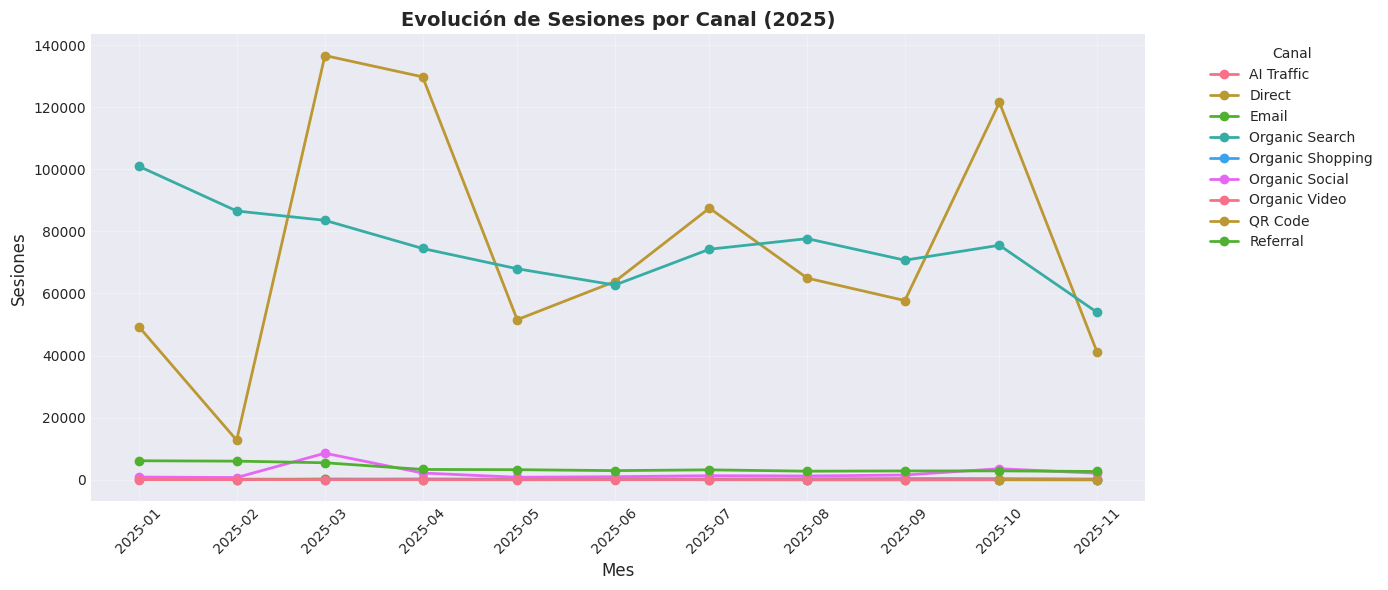

💾 Gráfico guardado


In [10]:
# Crear columna de fecha
df_raw['fecha'] = pd.to_datetime(
    df_raw[year_col].astype(str) + '-' + df_raw[month_col].astype(str) + '-01'
)

# Gráfico: Evolución de sesiones por canal
fig, ax = plt.subplots(figsize=(14, 6))

for canal in sorted(df_raw[canal_col].unique()):
    data_canal = df_raw[df_raw[canal_col] == canal].sort_values('fecha')
    ax.plot(data_canal['fecha'], data_canal[sessions_col], 
            marker='o', label=canal, linewidth=2, markersize=6)

ax.set_xlabel('Mes', fontsize=12)
ax.set_ylabel('Sesiones', fontsize=12)
ax.set_title('Evolución de Sesiones por Canal (2025)', fontsize=14, fontweight='bold')
ax.legend(title='Canal', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(RESULTS_FIGURES_EXPLORATORY / 'sessions_by_channel.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Gráfico guardado")

---
# 🧹 SECCIÓN 2: PREPARACIÓN Y LIMPIEZA DE DATOS
---

## 2.1 Transformación a snake_case

In [11]:
# Mapeo de columnas a snake_case
column_mapping = {
    'Year': 'year',
    'Month number': 'month',
    'Session Default Channel Group Custom (Recovery)': 'channel',
    'Sessions - GA4': 'sessions',
    'Bounces': 'bounces',
    'Total session duration - GA4': 'total_session_duration',
    'Views - GA4': 'views'
}

df_clean = df_raw.rename(columns=column_mapping)

print("✅ Columnas renombradas a snake_case")
print(f"\nColumnas del dataset limpio: {list(df_clean.columns)}")

✅ Columnas renombradas a snake_case

Columnas del dataset limpio: ['year', 'month', 'channel', 'sessions', 'bounces', 'total_session_duration', 'views', 'fecha']


## 2.2 Cálculo de métricas derivadas

In [12]:
# Calcular métricas derivadas
df_clean['bounce_rate'] = (df_clean['bounces'] / df_clean['sessions']) * 100
df_clean['views_per_session'] = df_clean['views'] / df_clean['sessions']
df_clean['avg_session_duration'] = df_clean['total_session_duration'] / df_clean['sessions']

# Crear columna de fecha
df_clean['ds'] = pd.to_datetime(
    df_clean['year'].astype(str) + '-' + df_clean['month'].astype(str) + '-01'
)

print("✅ Métricas derivadas calculadas:")
print("   - bounce_rate (%)")
print("   - views_per_session")
print("   - avg_session_duration (segundos)")

# Mostrar muestra
print("\n📊 Muestra de datos procesados:\n")
display(df_clean[['year', 'month', 'channel', 'sessions', 'bounce_rate', 
                   'views_per_session', 'avg_session_duration']].head(10))

✅ Métricas derivadas calculadas:
   - bounce_rate (%)
   - views_per_session
   - avg_session_duration (segundos)

📊 Muestra de datos procesados:



,year,month,channel,sessions,bounce_rate,views_per_session,avg_session_duration
0,2025,1,AI Traffic,135,5.19,1.47,152.96
1,2025,1,Organic Search,100968,7.22,1.90,224.72
2,2025,1,Referral,6109,17.17,2.22,250.86
3,2025,1,Organic Social,858,9.79,1.64,116.30
4,2025,1,Organic Video,47,4.26,2.89,303.98
5,2025,1,Direct,49275,2.71,1.95,149.88
6,2025,2,Direct,12724,2.92,1.76,238.69
7,2025,2,Email,2,50.00,7.00,492.00
8,2025,2,Organic Video,42,2.38,1.19,250.67
9,2025,2,Organic Social,706,2.41,2.42,228.68


## 2.3 Filtrado de canales (OPCIONAL)

In [13]:
# Configuración: usar todos los canales o filtrar
usar_todos_los_canales = True

if usar_todos_los_canales:
    df_final = df_clean.copy()
    print(f"✅ Usando TODOS los canales ({df_final['channel'].nunique()} canales)")
    print(f"\nCanales incluidos:")
    for canal in sorted(df_final['channel'].unique()):
        print(f"   - {canal}")
else:
    # Puedes personalizar esta lista
    canales_incluir = ['Organic Search', 'Direct', 'Referral']
    df_final = df_clean[df_clean['channel'].isin(canales_incluir)].copy()
    print(f"✅ Filtrado aplicado: {len(canales_incluir)} canales seleccionados")

✅ Usando TODOS los canales (9 canales)

Canales incluidos:
   - AI Traffic
   - Direct
   - Email
   - Organic Search
   - Organic Shopping
   - Organic Social
   - Organic Video
   - QR Code
   - Referral


## 2.4 Guardado de dataset limpio

In [14]:
# Seleccionar columnas finales
columnas_finales = [
    'year', 'month', 'channel', 'sessions', 'bounces', 
    'total_session_duration', 'views', 'bounce_rate', 
    'views_per_session', 'avg_session_duration', 'ds'
]

df_output = df_final[columnas_finales].copy()
df_output = df_output.sort_values(['year', 'month', 'channel']).reset_index(drop=True)

# Guardar
output_file = DATA_PROCESSED / 'dataset_clean.csv'
df_output.to_csv(output_file, index=False)

print(f"✅ Dataset limpio guardado en: {output_file}")
print(f"📊 Dimensiones: {df_output.shape[0]} filas x {df_output.shape[1]} columnas")

✅ Dataset limpio guardado en: ../data/processed/dataset_clean.csv
📊 Dimensiones: 82 filas x 11 columnas


---
# 🔮 SECCIÓN 3: MODELOS DE FORECASTING
---

## 3.1 Configuración de forecasting

In [15]:
# Configuración
metricas_forecast = ['sessions', 'bounce_rate', 'views_per_session', 'avg_session_duration']
canales = sorted(df_output['channel'].unique())
periodos_forecast = 12  # 12 meses de 2026

print(f"📊 Configuración de forecasting:")
print(f"\n   Métricas: {len(metricas_forecast)}")
for m in metricas_forecast:
    print(f"      - {m}")
print(f"\n   Canales: {len(canales)}")
for c in canales:
    print(f"      - {c}")
print(f"\n   Horizonte: {periodos_forecast} meses (2026)")
print(f"\n   Total de modelos: {len(metricas_forecast)} × {len(canales)} = {len(metricas_forecast) * len(canales)}")

📊 Configuración de forecasting:

   Métricas: 4
      - sessions
      - bounce_rate
      - views_per_session
      - avg_session_duration

   Canales: 9
      - AI Traffic
      - Direct
      - Email
      - Organic Search
      - Organic Shopping
      - Organic Social
      - Organic Video
      - QR Code
      - Referral

   Horizonte: 12 meses (2026)

   Total de modelos: 4 × 9 = 36


## 3.2 Función de forecasting

In [16]:
def crear_forecast_prophet(df_canal, metrica, periodos=12):
    """
    Crea forecast con Prophet
    """
    # Preparar datos
    df_prophet = df_canal[['ds', metrica]].rename(columns={metrica: 'y'})
    
    # Modelo
    model = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        interval_width=0.95
    )
    
    model.fit(df_prophet)
    
    # Predicciones
    future = model.make_future_dataframe(periods=periodos, freq='MS')
    forecast = model.predict(future)
    
    # Métricas de evaluación
    forecast_hist = forecast[forecast['ds'].isin(df_prophet['ds'])]
    valores_reales = df_prophet['y'].values
    valores_pred = forecast_hist['yhat'].values
    
    mae = np.mean(np.abs(valores_reales - valores_pred))
    rmse = np.sqrt(np.mean((valores_reales - valores_pred)**2))
    mape = np.mean(np.abs((valores_reales - valores_pred) / valores_reales)) * 100
    
    return model, forecast, {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

print("✅ Función de forecasting creada")

✅ Función de forecasting creada


## 3.3 Entrenamiento de modelos

In [17]:
# Entrenar modelos
resultados_forecasts = {}
metricas_evaluacion = {}

print("🚀 Entrenando modelos...\n")
print("="*70)

total = len(canales) * len(metricas_forecast)
actual = 0

for canal in canales:
    print(f"\n📊 Canal: {canal}")
    print("-" * 70)
    
    df_canal = df_output[df_output['channel'] == canal].sort_values('ds')
    resultados_forecasts[canal] = {}
    metricas_evaluacion[canal] = {}
    
    for metrica in metricas_forecast:
        actual += 1
        print(f"   [{actual}/{total}] {metrica}...", end=" ")
        
        model, forecast, metrics = crear_forecast_prophet(df_canal, metrica, periodos_forecast)
        
        resultados_forecasts[canal][metrica] = forecast
        metricas_evaluacion[canal][metrica] = metrics
        
        print(f"MAPE: {metrics['MAPE']:.2f}%")

print("\n" + "="*70)
print("✅ Todos los modelos entrenados")

02:20:43 - cmdstanpy - INFO - Chain [1] start processing


🚀 Entrenando modelos...


📊 Canal: AI Traffic
----------------------------------------------------------------------
   [1/36] sessions... 

02:20:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 16.49%
   [2/36] bounce_rate... 

02:20:43 - cmdstanpy - INFO - Chain [1] start processing
02:20:43 - cmdstanpy - INFO - Chain [1] done processing
02:20:43 - cmdstanpy - INFO - Chain [1] start processing
02:20:43 - cmdstanpy - INFO - Chain [1] done processing
02:20:43 - cmdstanpy - INFO - Chain [1] start processing
02:20:43 - cmdstanpy - INFO - Chain [1] done processing
02:20:44 - cmdstanpy - INFO - Chain [1] start processing


MAPE: 103.22%
   [3/36] views_per_session... MAPE: 5.64%
   [4/36] avg_session_duration... MAPE: 42.51%

📊 Canal: Direct
----------------------------------------------------------------------
   [5/36] sessions... 

02:20:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 77.14%
   [6/36] bounce_rate... 

02:20:44 - cmdstanpy - INFO - Chain [1] start processing
02:20:44 - cmdstanpy - INFO - Chain [1] done processing
02:20:44 - cmdstanpy - INFO - Chain [1] start processing
02:20:44 - cmdstanpy - INFO - Chain [1] done processing
02:20:44 - cmdstanpy - INFO - Chain [1] start processing
02:20:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 233.79%
   [7/36] views_per_session... MAPE: 13.56%
   [8/36] avg_session_duration... 

02:20:44 - cmdstanpy - INFO - Chain [1] start processing


MAPE: 28.18%

📊 Canal: Email
----------------------------------------------------------------------
   [9/36] sessions... 

02:20:44 - cmdstanpy - INFO - Chain [1] done processing
02:20:44 - cmdstanpy - INFO - Chain [1] start processing
02:20:44 - cmdstanpy - INFO - Chain [1] done processing
02:20:44 - cmdstanpy - INFO - Chain [1] start processing
02:20:44 - cmdstanpy - INFO - Chain [1] done processing
02:20:44 - cmdstanpy - INFO - Chain [1] start processing
02:20:44 - cmdstanpy - INFO - Chain [1] done processing
02:20:44 - cmdstanpy - INFO - Chain [1] start processing


MAPE: 658.15%
   [10/36] bounce_rate... MAPE: 643.41%
   [11/36] views_per_session... MAPE: 70.39%
   [12/36] avg_session_duration... MAPE: 271.85%

📊 Canal: Organic Search
----------------------------------------------------------------------
   [13/36] sessions... 

02:20:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 9.32%
   [14/36] bounce_rate... 

02:20:44 - cmdstanpy - INFO - Chain [1] start processing
02:20:44 - cmdstanpy - INFO - Chain [1] done processing
02:20:44 - cmdstanpy - INFO - Chain [1] start processing
02:20:44 - cmdstanpy - INFO - Chain [1] done processing
02:20:44 - cmdstanpy - INFO - Chain [1] start processing
02:20:44 - cmdstanpy - INFO - Chain [1] done processing
02:20:44 - cmdstanpy - INFO - Chain [1] start processing
02:20:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 40.20%
   [15/36] views_per_session... MAPE: 1.43%
   [16/36] avg_session_duration... MAPE: 3.15%

📊 Canal: Organic Shopping
----------------------------------------------------------------------
   [17/36] sessions... 

02:20:44 - cmdstanpy - INFO - Chain [1] start processing
02:20:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 263.61%
   [18/36] bounce_rate... MAPE: inf%
   [19/36] views_per_session... 

02:20:44 - cmdstanpy - INFO - Chain [1] start processing
02:20:44 - cmdstanpy - INFO - Chain [1] done processing
02:20:44 - cmdstanpy - INFO - Chain [1] start processing
02:20:44 - cmdstanpy - INFO - Chain [1] done processing
02:20:44 - cmdstanpy - INFO - Chain [1] start processing
02:20:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 94.56%
   [20/36] avg_session_duration... MAPE: inf%

📊 Canal: Organic Social
----------------------------------------------------------------------
   [21/36] sessions... MAPE: 91.41%
   [22/36] bounce_rate... 

02:20:44 - cmdstanpy - INFO - Chain [1] start processing
02:20:44 - cmdstanpy - INFO - Chain [1] done processing
02:20:45 - cmdstanpy - INFO - Chain [1] start processing
02:20:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 167.81%
   [23/36] views_per_session... MAPE: 12.44%
   [24/36] avg_session_duration... 

02:20:45 - cmdstanpy - INFO - Chain [1] start processing
02:20:45 - cmdstanpy - INFO - Chain [1] done processing
02:20:45 - cmdstanpy - INFO - Chain [1] start processing
02:20:45 - cmdstanpy - INFO - Chain [1] done processing
02:20:45 - cmdstanpy - INFO - Chain [1] start processing
02:20:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 45.43%

📊 Canal: Organic Video
----------------------------------------------------------------------
   [25/36] sessions... MAPE: 30.80%
   [26/36] bounce_rate... MAPE: 50.80%
   [27/36] views_per_session... 

02:20:45 - cmdstanpy - INFO - Chain [1] start processing
02:20:45 - cmdstanpy - INFO - Chain [1] done processing
02:20:45 - cmdstanpy - INFO - Chain [1] start processing
02:20:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 20.28%
   [28/36] avg_session_duration... MAPE: 39.31%

📊 Canal: QR Code
----------------------------------------------------------------------
   [29/36] sessions... 

02:20:45 - cmdstanpy - INFO - Chain [1] start processing
02:20:45 - cmdstanpy - INFO - Chain [1] done processing
02:20:45 - cmdstanpy - INFO - Chain [1] start processing


MAPE: 0.00%
   [30/36] bounce_rate... 

02:20:46 - cmdstanpy - INFO - Chain [1] done processing
02:20:46 - cmdstanpy - INFO - Chain [1] start processing


MAPE: 0.00%
   [31/36] views_per_session... 

02:20:46 - cmdstanpy - INFO - Chain [1] done processing
02:20:46 - cmdstanpy - INFO - Chain [1] start processing


MAPE: 0.00%
   [32/36] avg_session_duration... 

02:20:47 - cmdstanpy - INFO - Chain [1] done processing
02:20:47 - cmdstanpy - INFO - Chain [1] start processing
02:20:47 - cmdstanpy - INFO - Chain [1] done processing
02:20:47 - cmdstanpy - INFO - Chain [1] start processing
02:20:47 - cmdstanpy - INFO - Chain [1] done processing
02:20:47 - cmdstanpy - INFO - Chain [1] start processing
02:20:47 - cmdstanpy - INFO - Chain [1] done processing
02:20:47 - cmdstanpy - INFO - Chain [1] start processing
02:20:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 0.00%

📊 Canal: Referral
----------------------------------------------------------------------
   [33/36] sessions... MAPE: 17.40%
   [34/36] bounce_rate... MAPE: 41.90%
   [35/36] views_per_session... MAPE: 5.85%
   [36/36] avg_session_duration... MAPE: 10.85%

✅ Todos los modelos entrenados


## 3.4 Exportación de predicciones

In [18]:
# Consolidar predicciones 2026
predicciones_2026 = []

for canal in canales:
    for metrica in metricas_forecast:
        forecast = resultados_forecasts[canal][metrica]
        forecast_2026 = forecast[forecast['ds'].dt.year == 2026][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
        
        forecast_2026['channel'] = canal
        forecast_2026['metric'] = metrica
        forecast_2026['year'] = 2026
        forecast_2026['month'] = forecast_2026['ds'].dt.month
        
        forecast_2026 = forecast_2026.rename(columns={
            'yhat': 'predicted_value',
            'yhat_lower': 'lower_bound',
            'yhat_upper': 'upper_bound'
        })
        
        predicciones_2026.append(forecast_2026)

df_predicciones = pd.concat(predicciones_2026, ignore_index=True)
df_predicciones = df_predicciones[[
    'year', 'month', 'channel', 'metric', 
    'predicted_value', 'lower_bound', 'upper_bound', 'ds'
]].sort_values(['channel', 'metric', 'year', 'month']).reset_index(drop=True)

# Guardar
forecast_file = DATA_FORECASTS / 'forecasts_2026_all_channels.csv'
df_predicciones.to_csv(forecast_file, index=False)

print(f"✅ Predicciones guardadas en: {forecast_file}")
print(f"📊 Total de predicciones: {len(df_predicciones)}")

✅ Predicciones guardadas en: ../data/forecasts/forecasts_2026_all_channels.csv
📊 Total de predicciones: 396


---
# 📈 SECCIÓN 4: VISUALIZACIÓN Y REPORTES
---

## 4.1 Ajuste de bounce_rate (0-100%)

In [19]:
# Limitar bounce_rate a 0-100%
mask_bounce = df_predicciones['metric'] == 'bounce_rate'

print("🔧 Aplicando limitación de bounce_rate a 0-100%...")

df_predicciones.loc[mask_bounce, 'predicted_value'] = df_predicciones.loc[mask_bounce, 'predicted_value'].clip(0, 100)
df_predicciones.loc[mask_bounce, 'lower_bound'] = df_predicciones.loc[mask_bounce, 'lower_bound'].clip(0, 100)
df_predicciones.loc[mask_bounce, 'upper_bound'] = df_predicciones.loc[mask_bounce, 'upper_bound'].clip(0, 100)

print("✅ Bounce_rate limitado correctamente")

🔧 Aplicando limitación de bounce_rate a 0-100%...
✅ Bounce_rate limitado correctamente


## 4.2 Análisis de confiabilidad

In [20]:
# Identificar canales poco confiables
canales_confiabilidad = []

for canal in canales:
    df_canal_pred = df_predicciones[df_predicciones['channel'] == canal]
    df_canal_hist = df_output[df_output['channel'] == canal]
    
    volumen = df_canal_hist['sessions'].mean()
    
    metricas_positivas = ['sessions', 'views_per_session', 'avg_session_duration']
    negativos = df_canal_pred[
        df_canal_pred['metric'].isin(metricas_positivas) & 
        (df_canal_pred['predicted_value'] < 0)
    ].shape[0]
    
    problemas = []
    if volumen < 100:
        problemas.append('Bajo volumen')
    if negativos > 0:
        problemas.append('Valores negativos')
    
    confiabilidad = 'BAJA' if problemas else ('MEDIA' if volumen < 1000 else 'ALTA')
    
    canales_confiabilidad.append({
        'canal': canal,
        'volumen_promedio': volumen,
        'confiabilidad': confiabilidad,
        'problemas': ', '.join(problemas) if problemas else 'Ninguno'
    })

df_confiabilidad = pd.DataFrame(canales_confiabilidad).sort_values('volumen_promedio', ascending=False)

print("📊 Análisis de confiabilidad:\n")
display(df_confiabilidad)

# Guardar
df_confiabilidad.to_csv(RESULTS_REPORTS / 'canales_confiabilidad.csv', index=False)
print(f"\n💾 Análisis guardado")

📊 Análisis de confiabilidad:



,canal,volumen_promedio,confiabilidad,problemas
3,Organic Search,75314.09,ALTA,Ninguno
1,Direct,74243.45,ALTA,Ninguno
8,Referral,3758.09,BAJA,Valores negativos
5,Organic Social,2153.64,ALTA,Ninguno
0,AI Traffic,248.00,MEDIA,Ninguno
2,Email,79.60,BAJA,"Bajo volumen, Valores negativos"
6,Organic Video,32.18,BAJA,"Bajo volumen, Valores negativos"
7,QR Code,25.50,BAJA,"Bajo volumen, Valores negativos"
4,Organic Shopping,9.00,BAJA,"Bajo volumen, Valores negativos"



💾 Análisis guardado


## 4.3 Tablas resumen por canal

In [21]:
# Crear tablas resumen (métricas × meses) con duración en HH:MM:SS
def crear_tabla_resumen(canal):
    df_canal = df_predicciones[df_predicciones['channel'] == canal].copy()
    df_canal['mes'] = df_canal['ds'].dt.strftime('%b-%y')
    
    tabla = df_canal.pivot(index='metric', columns='mes', values='predicted_value')
    
    meses_orden = df_canal.sort_values('ds')['mes'].unique()
    tabla = tabla[meses_orden]
    tabla['Promedio'] = tabla.mean(axis=1)
    
    # Crear fila adicional con duración en formato HH:MM:SS
    if 'avg_session_duration' in tabla.index:
        duracion_seg = tabla.loc['avg_session_duration'].copy()
        duracion_formateada = duracion_seg.apply(segundos_a_hhmm_ss)
        
        # Agregar fila formateada justo después de la fila en segundos
        tabla.loc['avg_session_duration_formatted'] = duracion_formateada
    
    nombres = {
        'sessions': 'Sesiones',
        'bounce_rate': 'Bounce Rate (%)',
        'views_per_session': 'Vistas/Sesión',
        'avg_session_duration': 'Duración Avg (seg)',
        'avg_session_duration_formatted': 'Duración Avg (HH:MM:SS)'
    }
    tabla = tabla.rename(index=nombres)
    
    return tabla.round(2)

# Generar y mostrar tablas
print("📊 TABLAS RESUMEN POR CANAL\n")
print("="*80)

tablas = {}
for canal in canales:
    print(f"\n📈 {canal}")
    print("-"*80)
    
    conf = df_confiabilidad[df_confiabilidad['canal'] == canal]['confiabilidad'].values[0]
    if conf == 'BAJA':
        print("⚠️ ADVERTENCIA: Confiabilidad BAJA\n")
    
    tabla = crear_tabla_resumen(canal)
    tablas[canal] = tabla
    display(tabla)

print("\n" + "="*80)

📊 TABLAS RESUMEN POR CANAL


📈 AI Traffic
--------------------------------------------------------------------------------


mes,Jan-26,Feb-26,Mar-26,Apr-26,May-26,Jun-26,Jul-26,Aug-26,Sep-26,Oct-26,Nov-26,Promedio
metric,,,,,,,,,,,,
Duración Avg (seg),280.22,286.69,292.52,298.99,305.24,311.70,317.96,324.42,330.88,337.14,343.60,311.76
Bounce Rate (%),31.98,33.83,35.50,37.35,39.14,40.99,42.78,44.63,46.48,48.26,50.11,41.00
Sesiones,373.31,391.49,407.90,426.07,443.65,461.82,479.41,497.58,515.75,533.34,551.51,461.98
Vistas/Sesión,1.55,1.56,1.56,1.57,1.57,1.58,1.58,1.58,1.59,1.59,1.60,1.58
Duración Avg (HH:MM:SS),00:04:40,00:04:46,00:04:52,00:04:58,00:05:05,00:05:11,00:05:17,00:05:24,00:05:30,00:05:37,00:05:43,00:05:11



📈 Direct
--------------------------------------------------------------------------------


mes,Jan-26,Feb-26,Mar-26,Apr-26,May-26,Jun-26,Jul-26,Aug-26,Sep-26,Oct-26,Nov-26,Promedio
metric,,,,,,,,,,,,
Duración Avg (seg),86.18,81.97,78.17,73.96,69.89,65.68,61.61,57.40,53.19,49.12,44.91,65.64
Bounce Rate (%),56.03,58.91,61.51,64.39,67.18,70.06,72.84,75.72,78.60,81.39,84.27,70.08
Sesiones,78068.13,78618.40,79115.41,79665.68,80198.19,80748.46,81280.97,81831.24,82381.50,82914.02,83464.28,80753.30
Vistas/Sesión,0.78,0.71,0.65,0.58,0.51,0.44,0.38,0.31,0.24,0.17,0.10,0.44
Duración Avg (HH:MM:SS),00:01:26,00:01:21,00:01:18,00:01:13,00:01:09,00:01:05,00:01:01,00:00:57,00:00:53,00:00:49,00:00:44,00:01:05



📈 Email
--------------------------------------------------------------------------------
⚠️ ADVERTENCIA: Confiabilidad BAJA



mes,Jan-26,Feb-26,Mar-26,Apr-26,May-26,Jun-26,Jul-26,Aug-26,Sep-26,Oct-26,Nov-26,Promedio
metric,,,,,,,,,,,,
Duración Avg (seg),23.61,4.10,-13.51,-33.02,-51.89,-71.39,-90.27,-109.77,-129.28,-148.15,-167.66,-71.57
Bounce Rate (%),82.96,88.66,93.81,99.51,100.00,100.00,100.00,100.00,100.00,100.00,100.00,96.81
Sesiones,40.88,34.84,29.39,23.35,17.51,11.48,5.64,-0.40,-6.43,-12.28,-18.31,11.42
Vistas/Sesión,-0.52,-0.87,-1.19,-1.54,-1.88,-2.23,-2.58,-2.93,-3.28,-3.62,-3.97,-2.24
Duración Avg (HH:MM:SS),00:00:23,00:00:04,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00



📈 Organic Search
--------------------------------------------------------------------------------


mes,Jan-26,Feb-26,Mar-26,Apr-26,May-26,Jun-26,Jul-26,Aug-26,Sep-26,Oct-26,Nov-26,Promedio
metric,,,,,,,,,,,,
Duración Avg (seg),216.96,215.98,215.09,214.12,213.17,212.19,211.24,210.26,209.28,208.33,207.35,212.18
Bounce Rate (%),28.18,29.88,31.42,33.12,34.76,36.46,38.11,39.81,41.51,43.15,44.85,36.48
Sesiones,55954.86,53149.24,50615.13,47809.51,45094.39,42288.77,39573.66,36768.04,33962.42,31247.30,28441.68,42264.09
Vistas/Sesión,1.71,1.70,1.69,1.69,1.68,1.67,1.66,1.66,1.65,1.64,1.64,1.67
Duración Avg (HH:MM:SS),00:03:36,00:03:35,00:03:35,00:03:34,00:03:33,00:03:32,00:03:31,00:03:30,00:03:29,00:03:28,00:03:27,00:03:32



📈 Organic Shopping
--------------------------------------------------------------------------------
⚠️ ADVERTENCIA: Confiabilidad BAJA



mes,Jan-26,Feb-26,Mar-26,Apr-26,May-26,Jun-26,Jul-26,Aug-26,Sep-26,Oct-26,Nov-26,Promedio
metric,,,,,,,,,,,,
Duración Avg (seg),7189.07,7931.51,8602.11,9344.55,10063.04,10805.49,11523.98,12266.42,13008.87,13727.36,14469.80,10812.02
Bounce Rate (%),97.74,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,99.79
Sesiones,-7.41,-10.73,-13.73,-17.05,-20.27,-23.59,-26.80,-30.13,-33.45,-36.66,-39.99,-23.62
Vistas/Sesión,0.58,0.53,0.49,0.45,0.41,0.37,0.32,0.28,0.24,0.19,0.15,0.36
Duración Avg (HH:MM:SS),01:59:49,02:12:11,02:23:22,02:35:44,02:47:43,03:00:05,03:12:03,03:24:26,03:36:48,03:48:47,04:01:09,03:00:12



📈 Organic Social
--------------------------------------------------------------------------------


mes,Jan-26,Feb-26,Mar-26,Apr-26,May-26,Jun-26,Jul-26,Aug-26,Sep-26,Oct-26,Nov-26,Promedio
metric,,,,,,,,,,,,
Duración Avg (seg),106.09,105.25,104.49,103.65,102.83,101.99,101.18,100.34,99.50,98.68,97.84,101.98
Bounce Rate (%),50.93,53.55,55.92,58.54,61.08,63.70,66.24,68.86,71.48,74.02,76.64,63.72
Sesiones,1816.94,1768.13,1724.03,1675.22,1627.97,1579.16,1531.91,1483.10,1434.28,1387.04,1338.22,1578.73
Vistas/Sesión,1.12,1.07,1.02,0.96,0.91,0.85,0.80,0.74,0.69,0.63,0.58,0.85
Duración Avg (HH:MM:SS),00:01:46,00:01:45,00:01:44,00:01:43,00:01:42,00:01:41,00:01:41,00:01:40,00:01:39,00:01:38,00:01:37,00:01:41



📈 Organic Video
--------------------------------------------------------------------------------
⚠️ ADVERTENCIA: Confiabilidad BAJA



mes,Jan-26,Feb-26,Mar-26,Apr-26,May-26,Jun-26,Jul-26,Aug-26,Sep-26,Oct-26,Nov-26,Promedio
metric,,,,,,,,,,,,
Duración Avg (seg),196.36,190.45,185.10,179.19,173.46,167.54,161.82,155.90,149.99,144.26,138.34,167.49
Bounce Rate (%),40.14,43.09,45.76,48.71,51.56,54.51,57.37,60.32,63.27,66.13,69.08,54.54
Sesiones,13.47,10.76,8.31,5.60,2.98,0.26,-2.36,-5.07,-7.78,-10.41,-13.12,0.24
Vistas/Sesión,1.46,1.41,1.37,1.32,1.27,1.22,1.17,1.12,1.07,1.02,0.97,1.22
Duración Avg (HH:MM:SS),00:03:16,00:03:10,00:03:05,00:02:59,00:02:53,00:02:47,00:02:41,00:02:35,00:02:29,00:02:24,00:02:18,00:02:47



📈 QR Code
--------------------------------------------------------------------------------
⚠️ ADVERTENCIA: Confiabilidad BAJA



mes,Jan-26,Feb-26,Mar-26,Apr-26,May-26,Jun-26,Jul-26,Aug-26,Sep-26,Oct-26,Nov-26,Promedio
metric,,,,,,,,,,,,
Duración Avg (seg),-891.18,-1437.64,-1931.22,-2477.68,-3006.51,-3552.97,-4081.80,-4628.27,-5174.73,-5703.56,-6250.02,-3557.78
Bounce Rate (%),85.23,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,98.66
Sesiones,-55.94,-88.94,-118.74,-151.74,-183.68,-216.68,-248.61,-281.61,-314.61,-346.55,-379.55,-216.97
Vistas/Sesión,-3.87,-6.29,-8.48,-10.90,-13.24,-15.67,-18.01,-20.43,-22.85,-25.19,-27.61,-15.69
Duración Avg (HH:MM:SS),00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00



📈 Referral
--------------------------------------------------------------------------------
⚠️ ADVERTENCIA: Confiabilidad BAJA



mes,Jan-26,Feb-26,Mar-26,Apr-26,May-26,Jun-26,Jul-26,Aug-26,Sep-26,Oct-26,Nov-26,Promedio
metric,,,,,,,,,,,,
Duración Avg (seg),438.73,453.64,467.09,481.99,496.41,511.31,525.73,540.63,555.54,569.96,584.86,511.45
Bounce Rate (%),29.78,31.19,32.46,33.87,35.24,36.65,38.01,39.42,40.83,42.19,43.60,36.66
Sesiones,1282.83,923.84,599.60,240.62,-106.78,-465.77,-813.17,-1172.15,-1531.14,-1878.54,-2237.52,-468.93
Vistas/Sesión,2.37,2.36,2.36,2.36,2.35,2.35,2.35,2.34,2.34,2.34,2.33,2.35
Duración Avg (HH:MM:SS),00:07:18,00:07:33,00:07:47,00:08:01,00:08:16,00:08:31,00:08:45,00:09:00,00:09:15,00:09:29,00:09:44,00:08:31


In [22]:
# Exportar tablas a Excel con formato HH:MM:SS
excel_file = RESULTS_REPORTS / 'tablas_resumen_2026.xlsx'

with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
    for canal, tabla in tablas.items():
        sheet_name = canal[:31]
        tabla.to_excel(writer, sheet_name=sheet_name)

print(f"💾 Tablas exportadas a: {excel_file}")
print(f"\n✅ Nota: Las tablas incluyen duración en segundos Y en formato HH:MM:SS")

💾 Tablas exportadas a: ../results/reports/tablas_resumen_2026.xlsx

✅ Nota: Las tablas incluyen duración en segundos Y en formato HH:MM:SS


## 4.4 Gráficos comparativos (TODAS las métricas)

📊 Generando gráficos comparativos para todas las métricas...


📈 Canal: AI Traffic
----------------------------------------------------------------------
   Gráfico: Sesiones


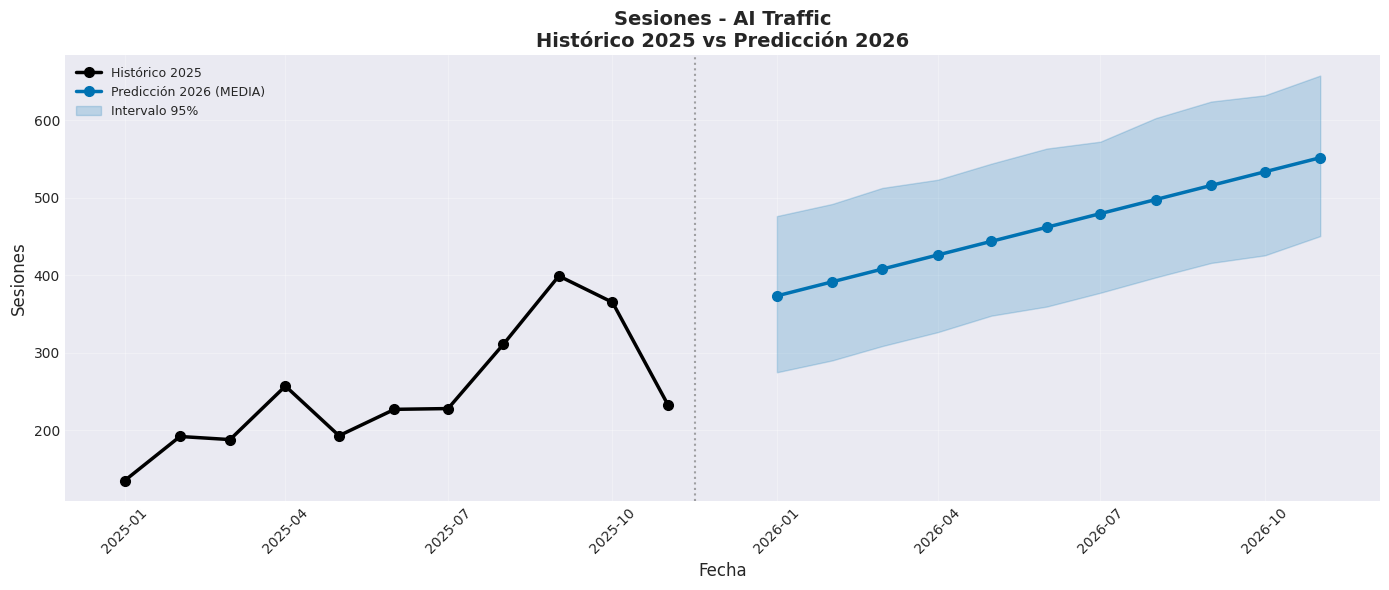

   Gráfico: Bounce Rate (%)


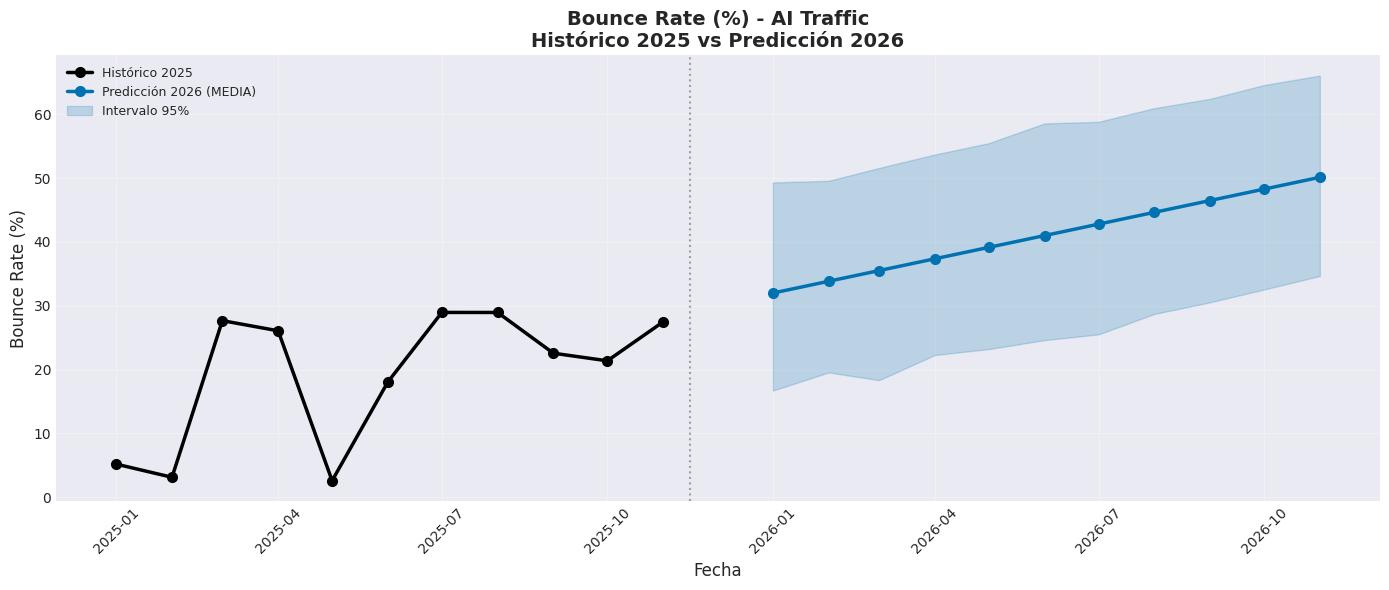

   Gráfico: Vistas por Sesión


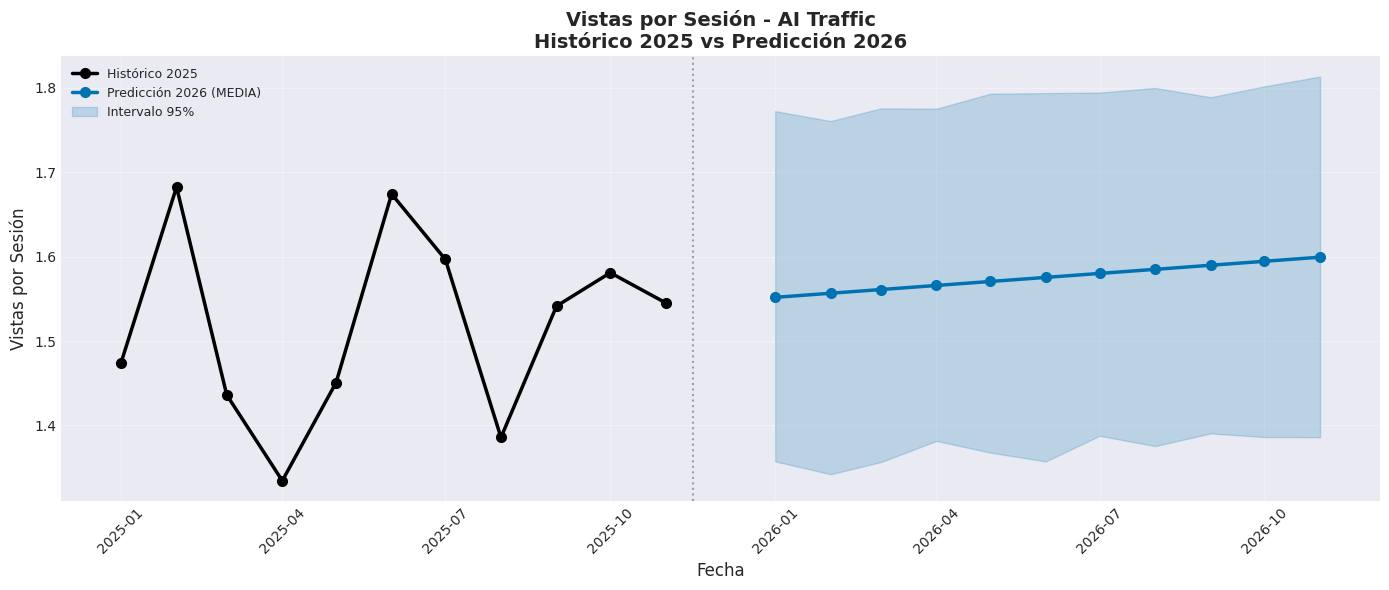

   Gráfico: Duración Promedio (segundos)


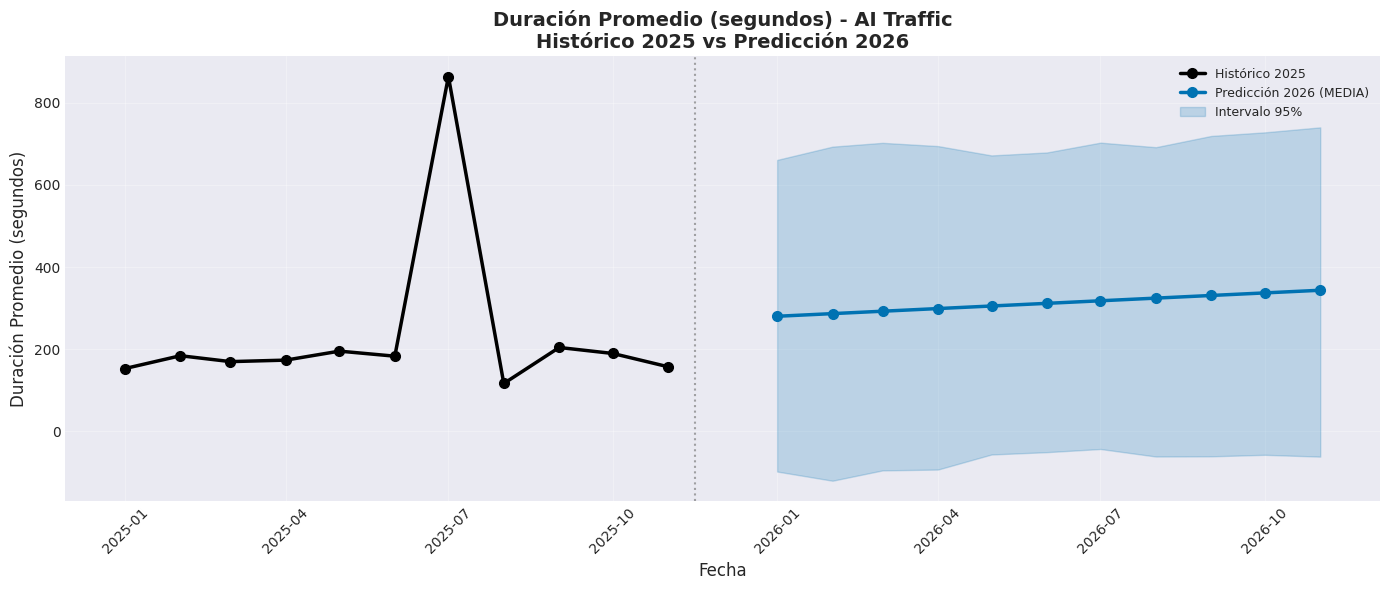


📈 Canal: Direct
----------------------------------------------------------------------
   Gráfico: Sesiones


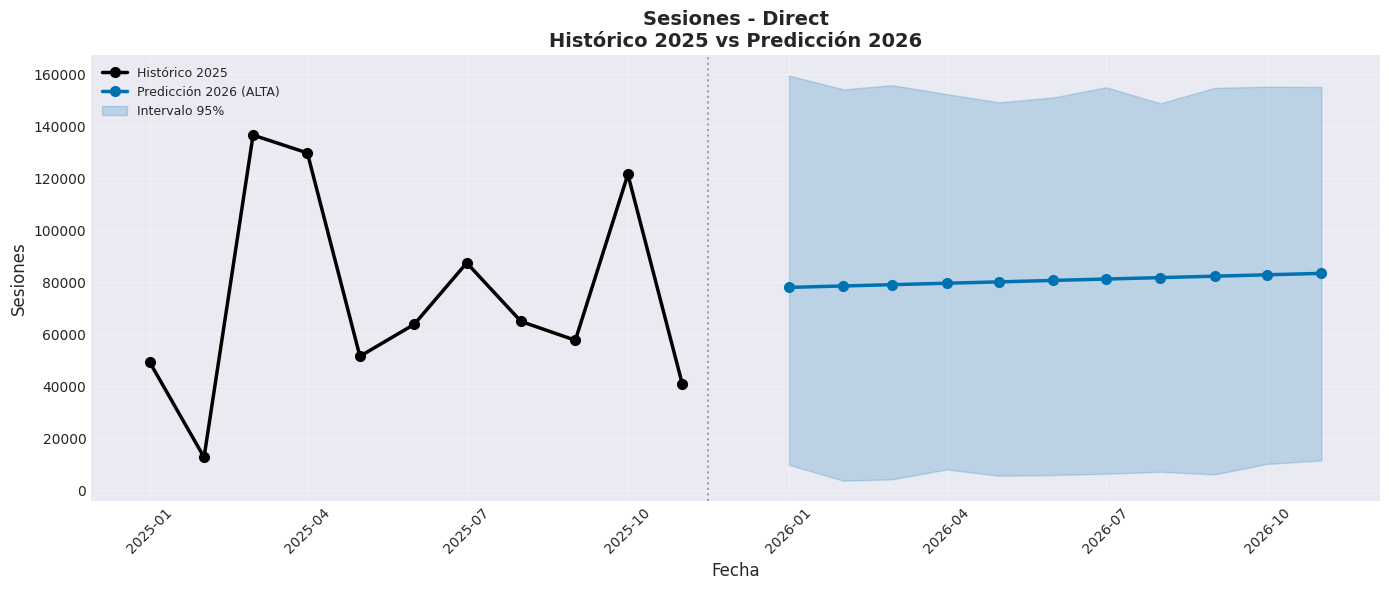

   Gráfico: Bounce Rate (%)


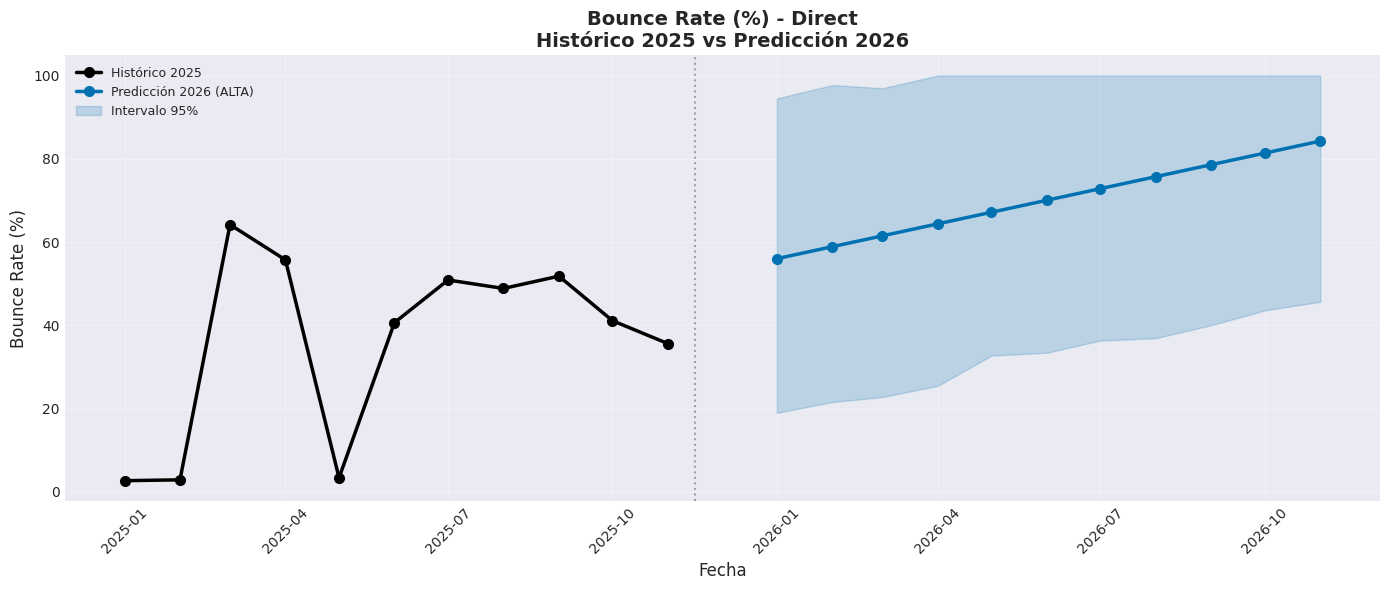

   Gráfico: Vistas por Sesión


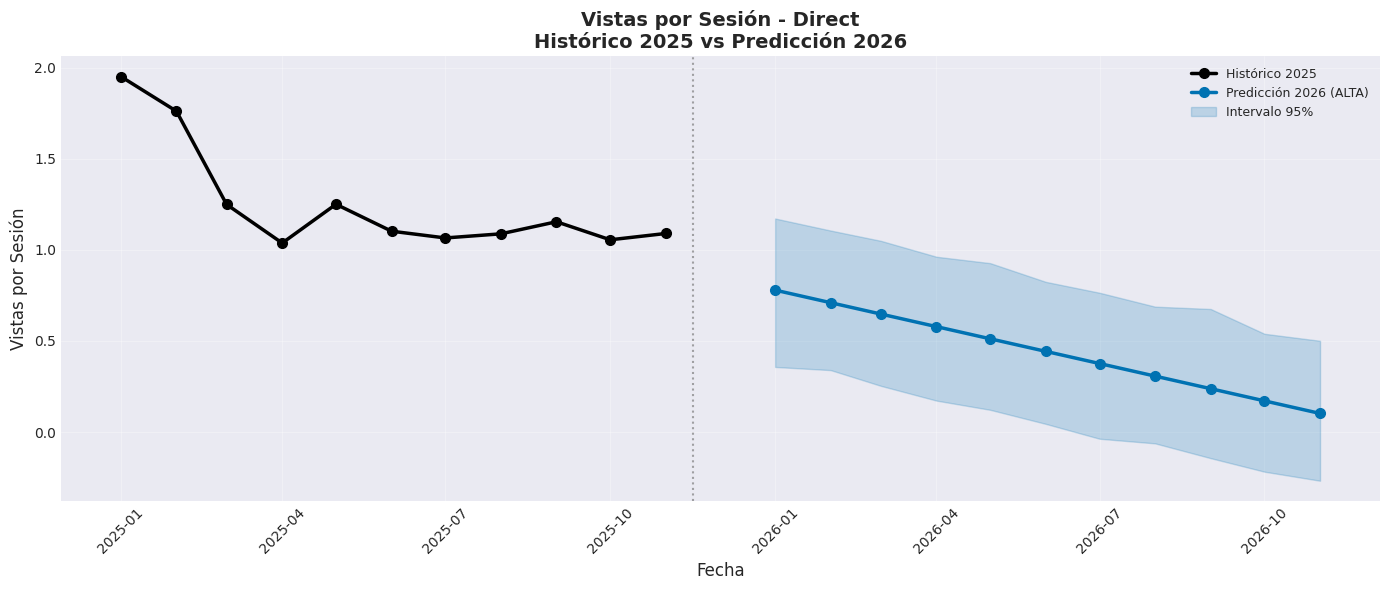

   Gráfico: Duración Promedio (segundos)


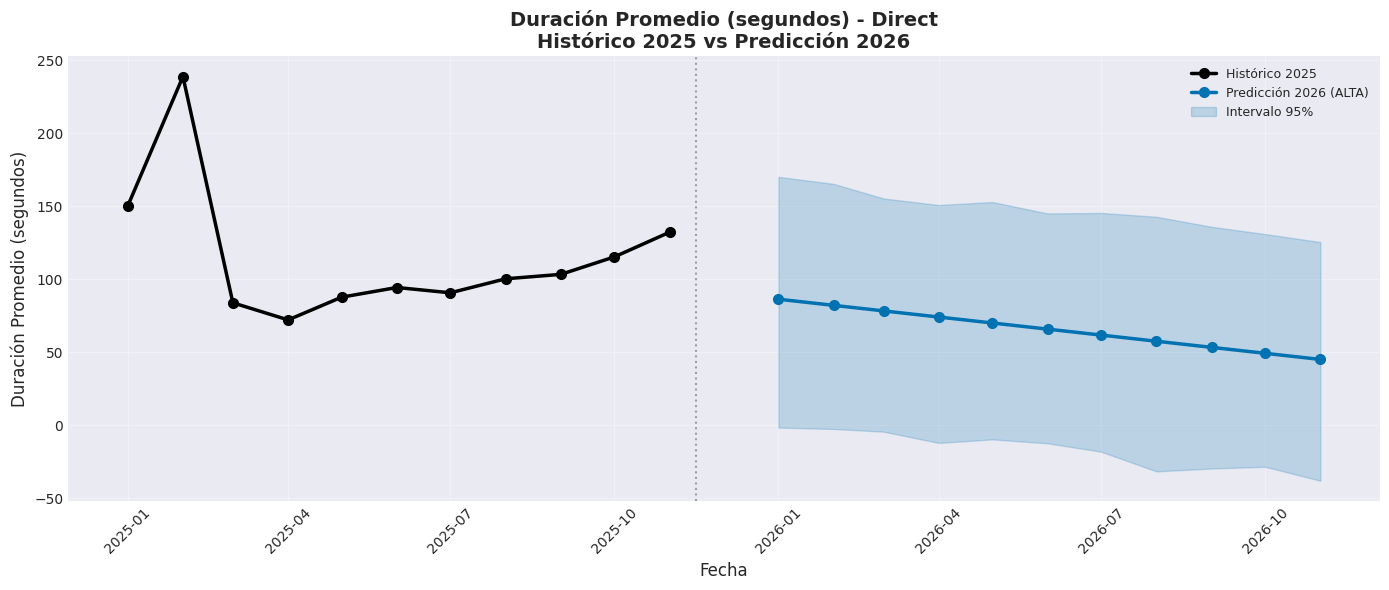


📈 Canal: Email
----------------------------------------------------------------------
   Gráfico: Sesiones


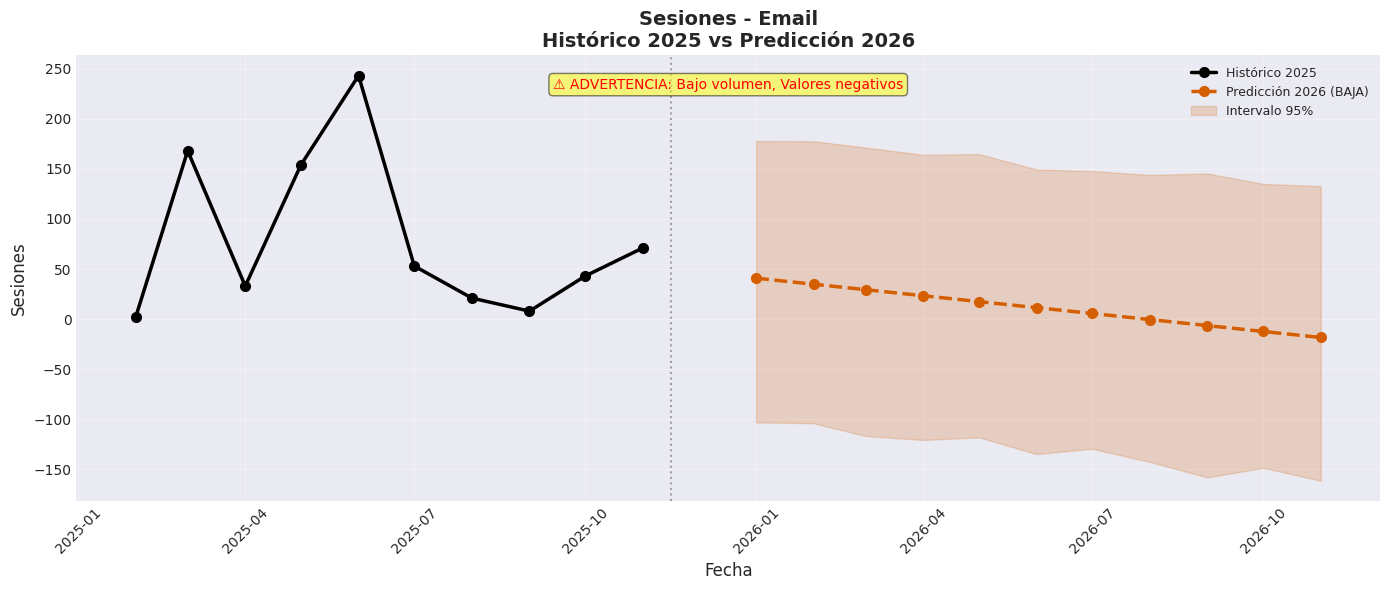

   Gráfico: Bounce Rate (%)


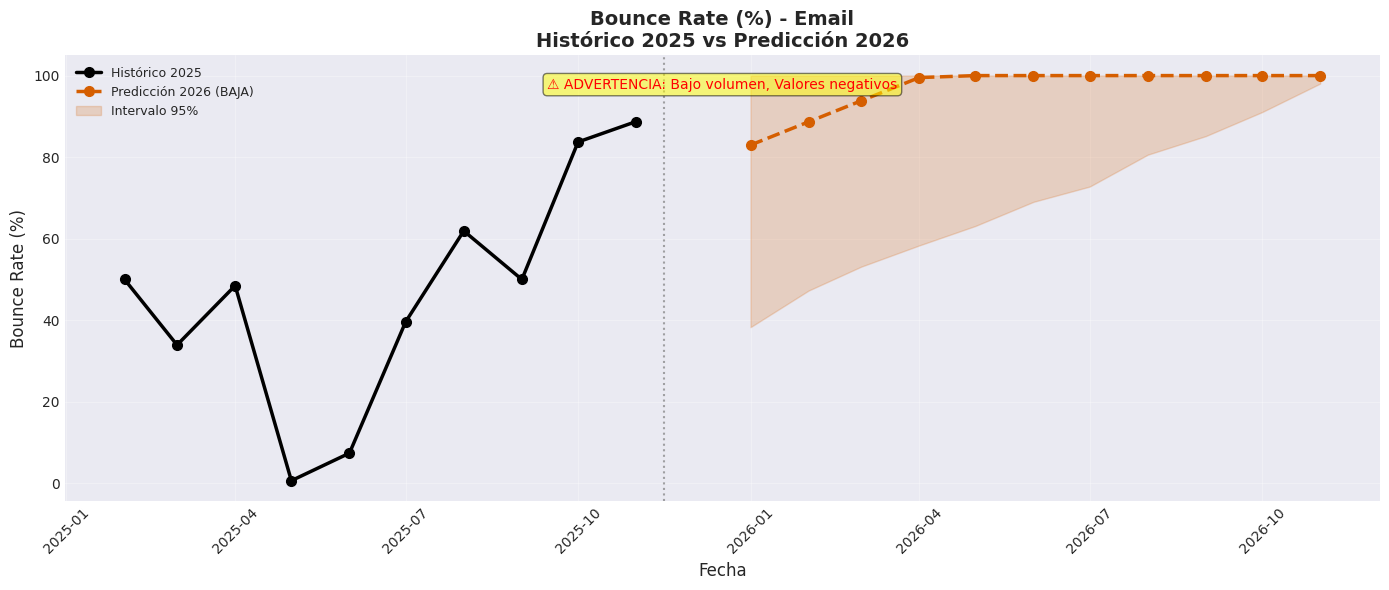

   Gráfico: Vistas por Sesión


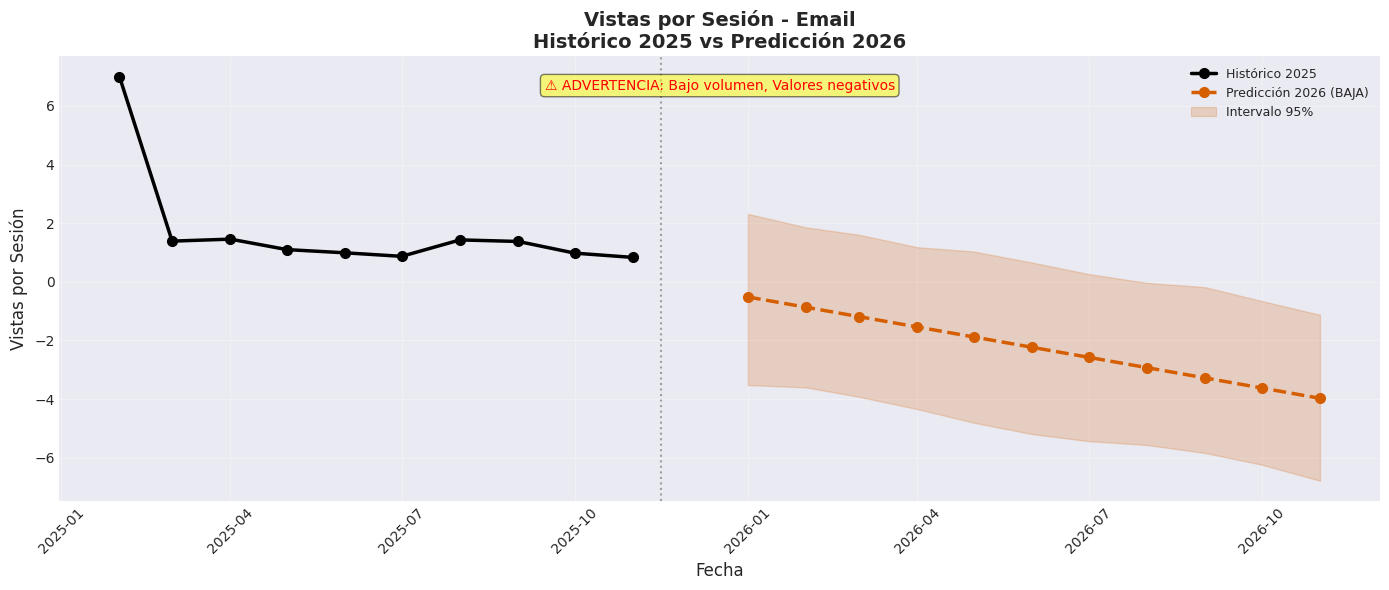

   Gráfico: Duración Promedio (segundos)


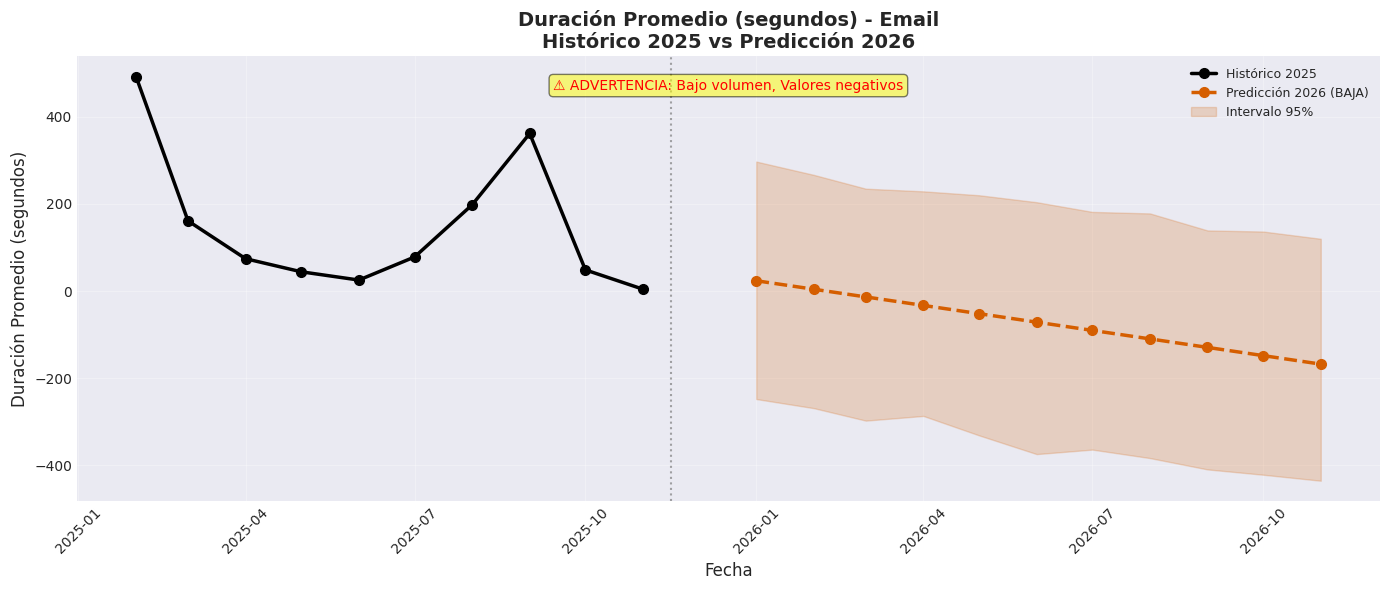


📈 Canal: Organic Search
----------------------------------------------------------------------
   Gráfico: Sesiones


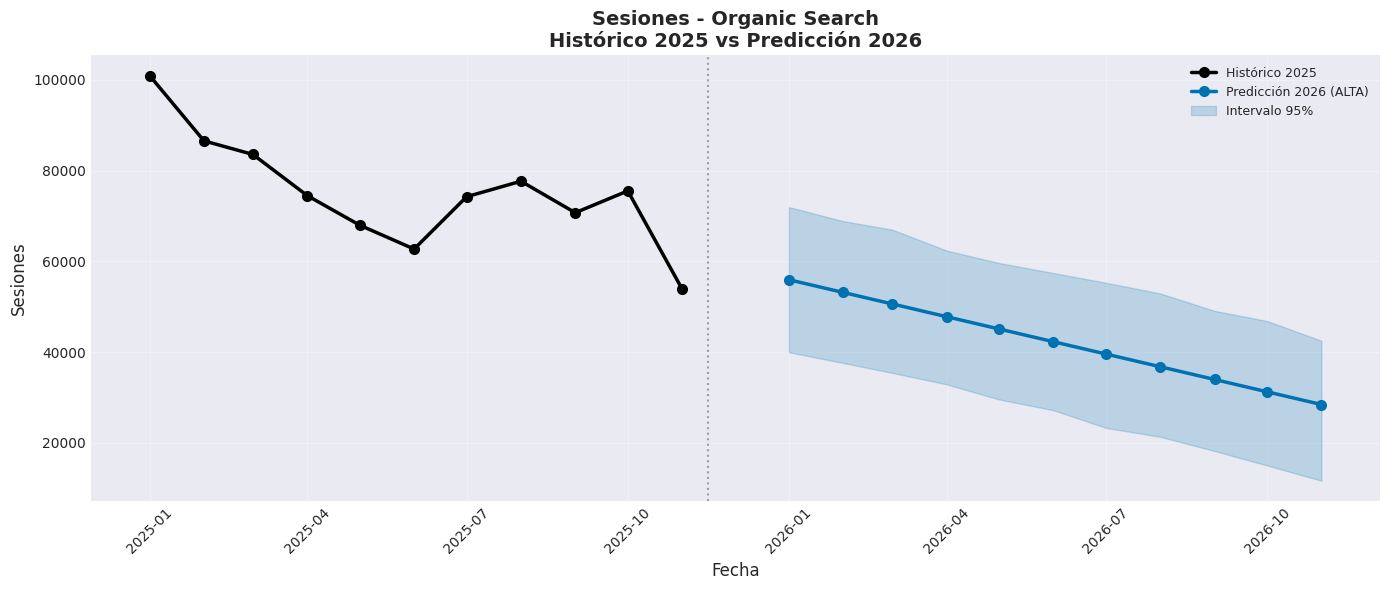

   Gráfico: Bounce Rate (%)


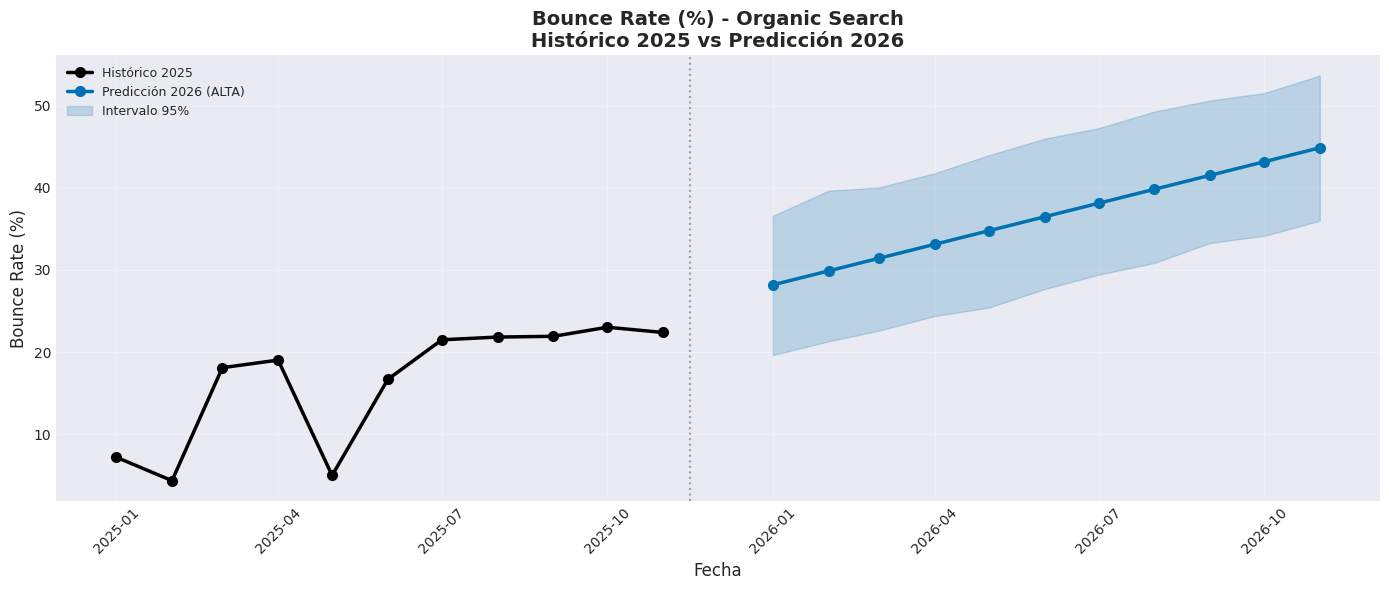

   Gráfico: Vistas por Sesión


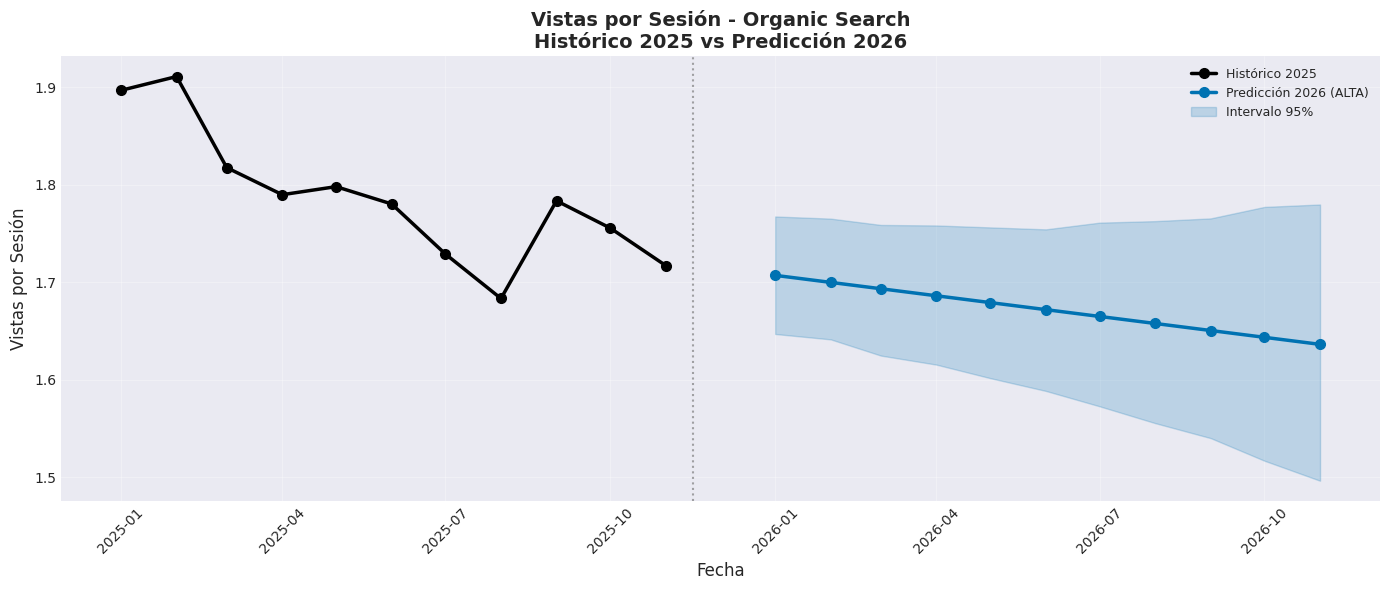

   Gráfico: Duración Promedio (segundos)


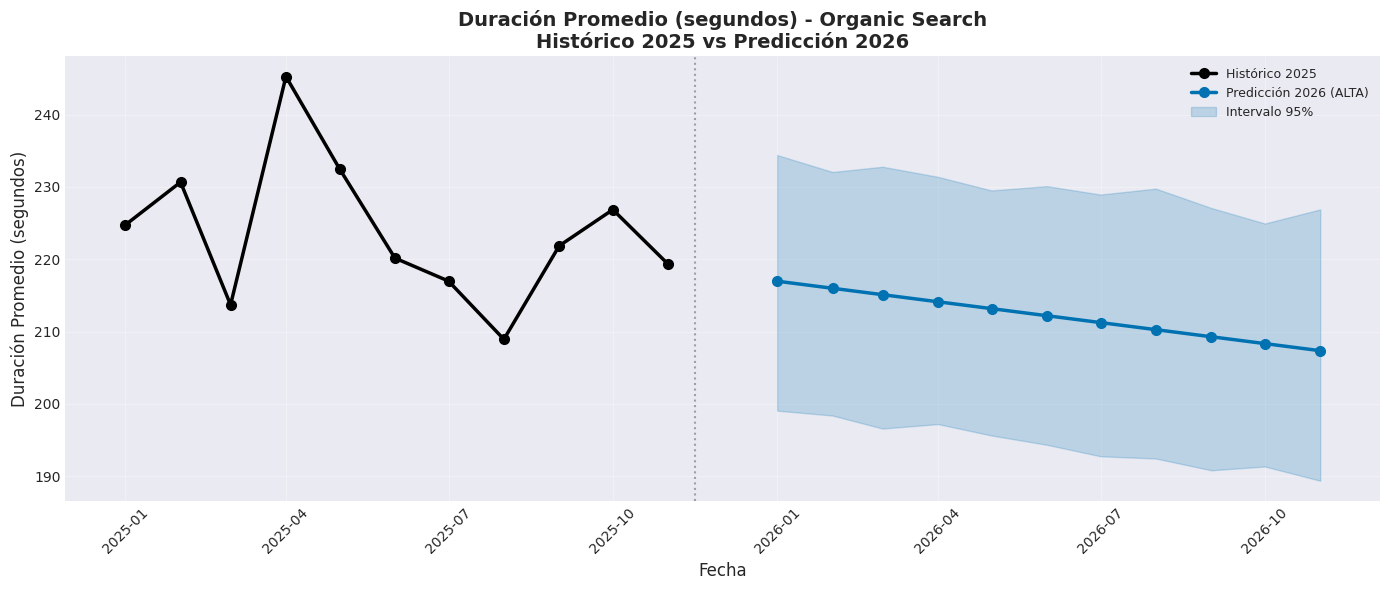


📈 Canal: Organic Shopping
----------------------------------------------------------------------
   Gráfico: Sesiones


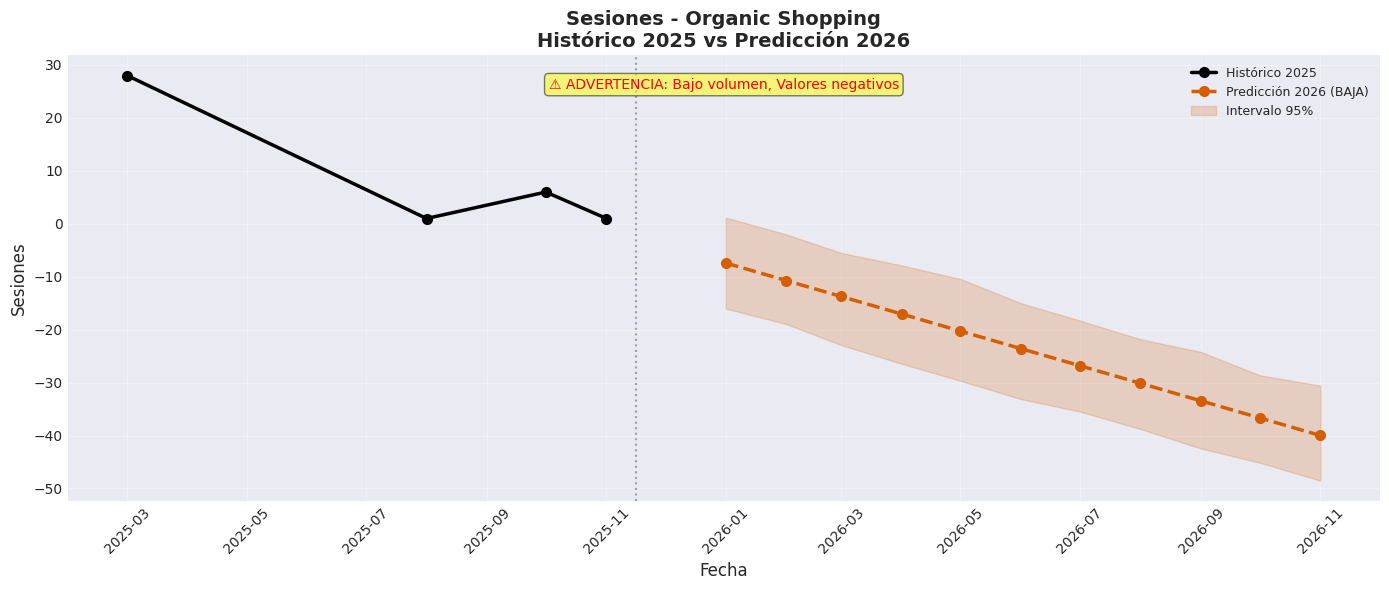

   Gráfico: Bounce Rate (%)


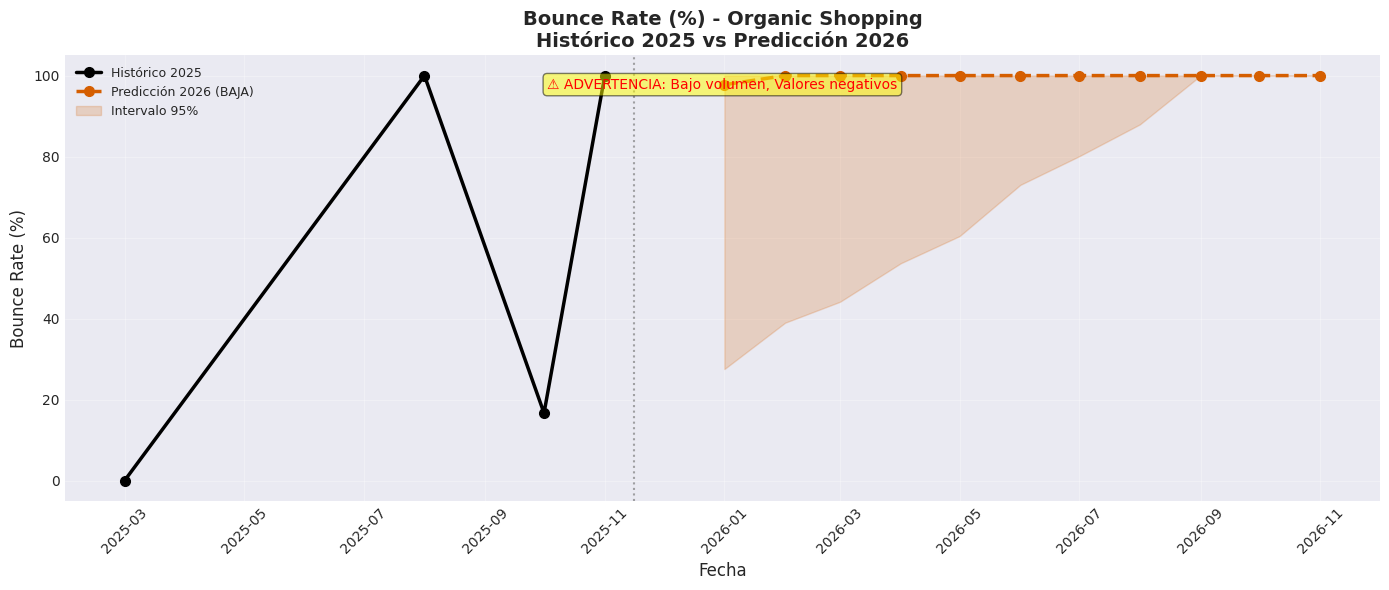

   Gráfico: Vistas por Sesión


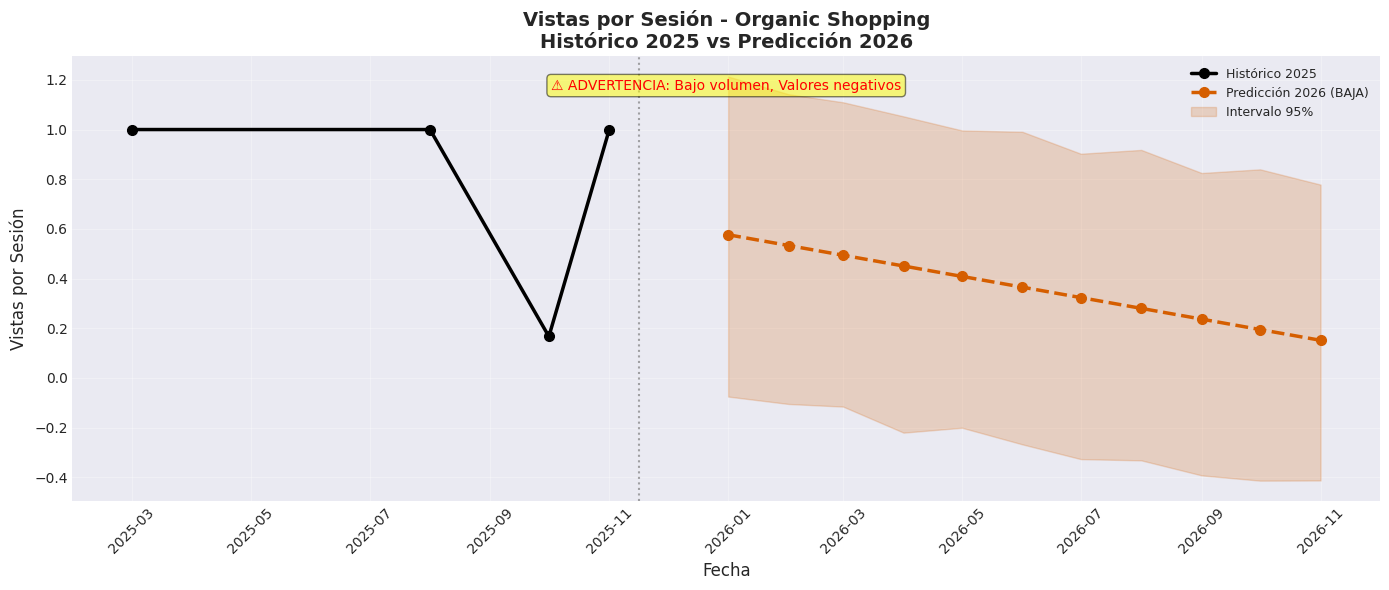

   Gráfico: Duración Promedio (segundos)


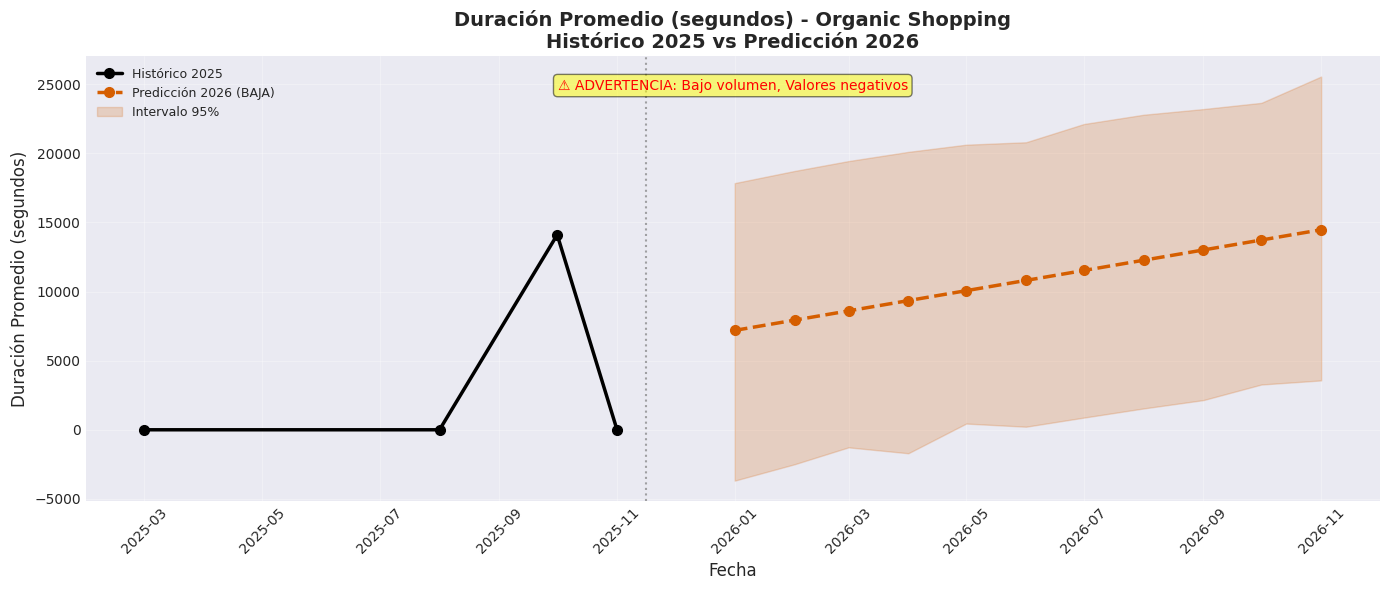


📈 Canal: Organic Social
----------------------------------------------------------------------
   Gráfico: Sesiones


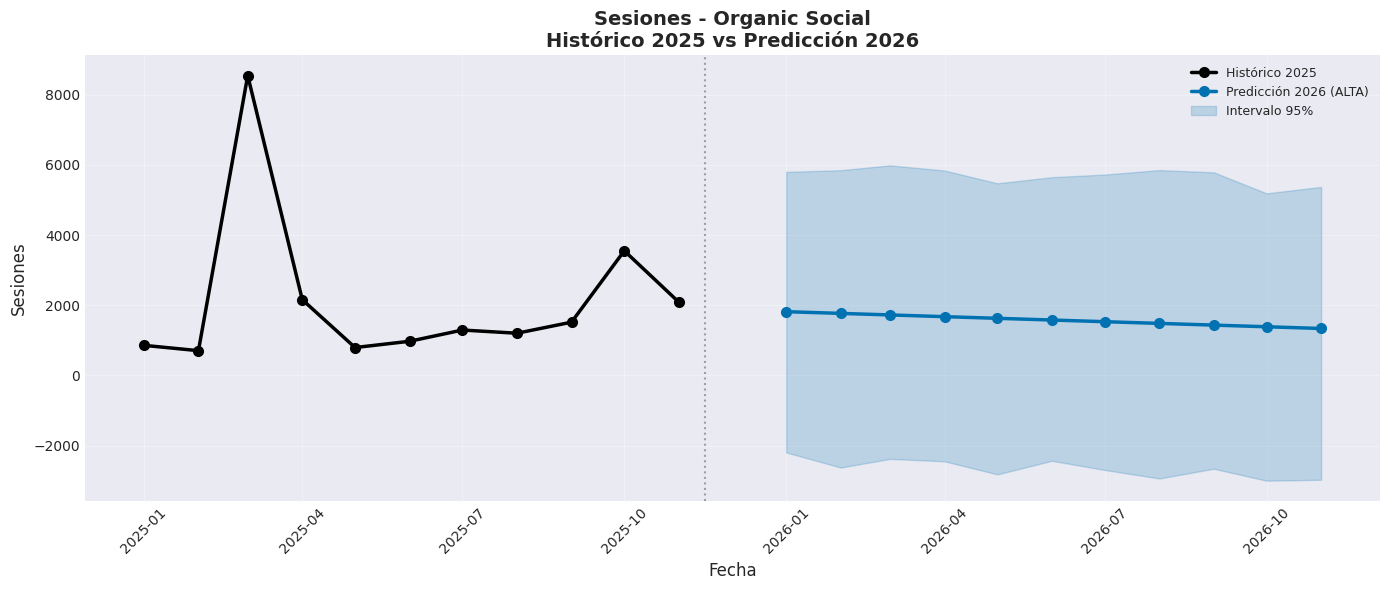

   Gráfico: Bounce Rate (%)


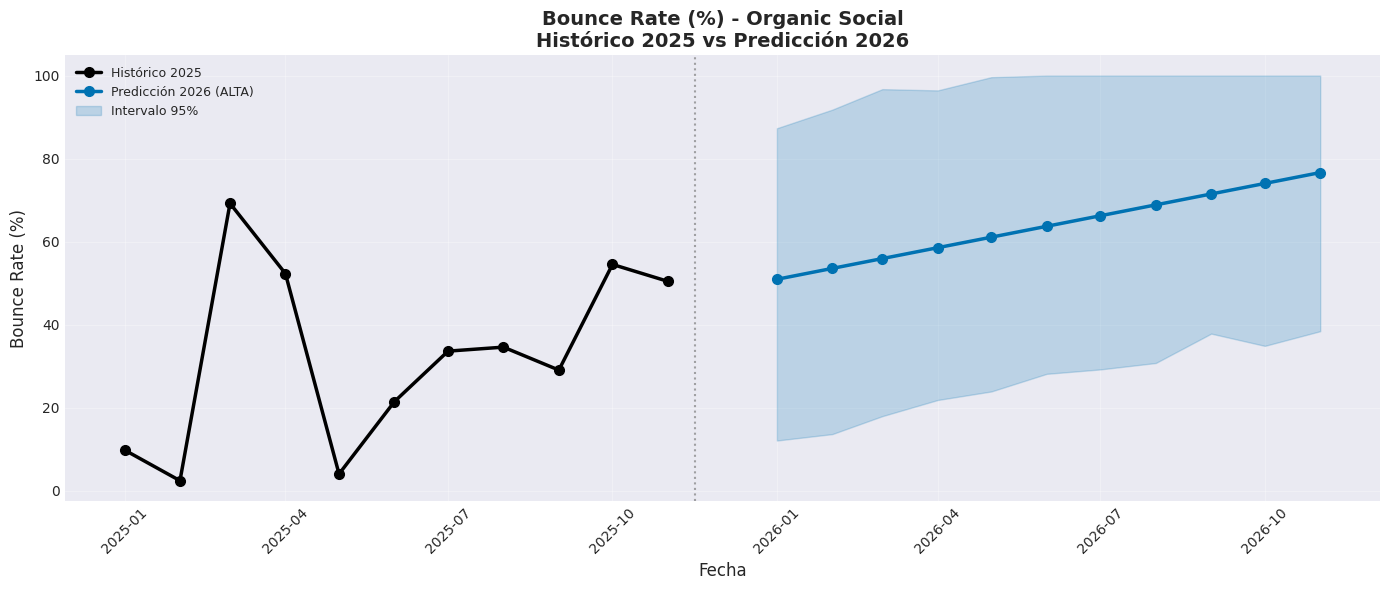

   Gráfico: Vistas por Sesión


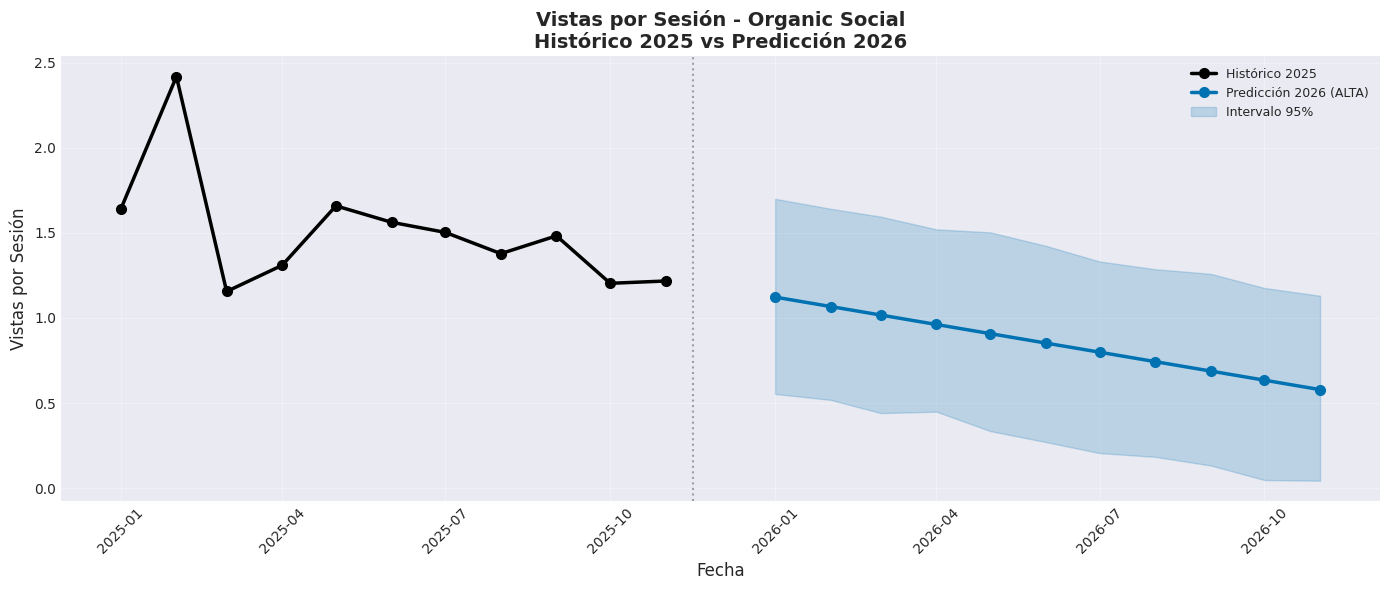

   Gráfico: Duración Promedio (segundos)


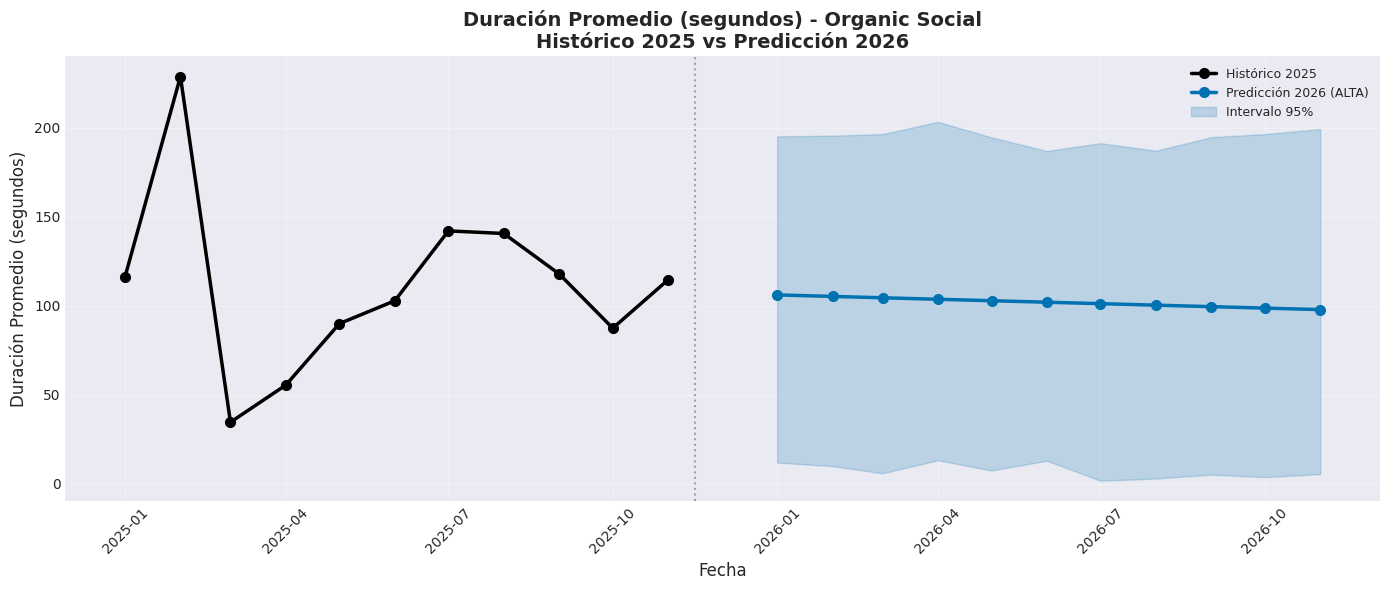


📈 Canal: Organic Video
----------------------------------------------------------------------
   Gráfico: Sesiones


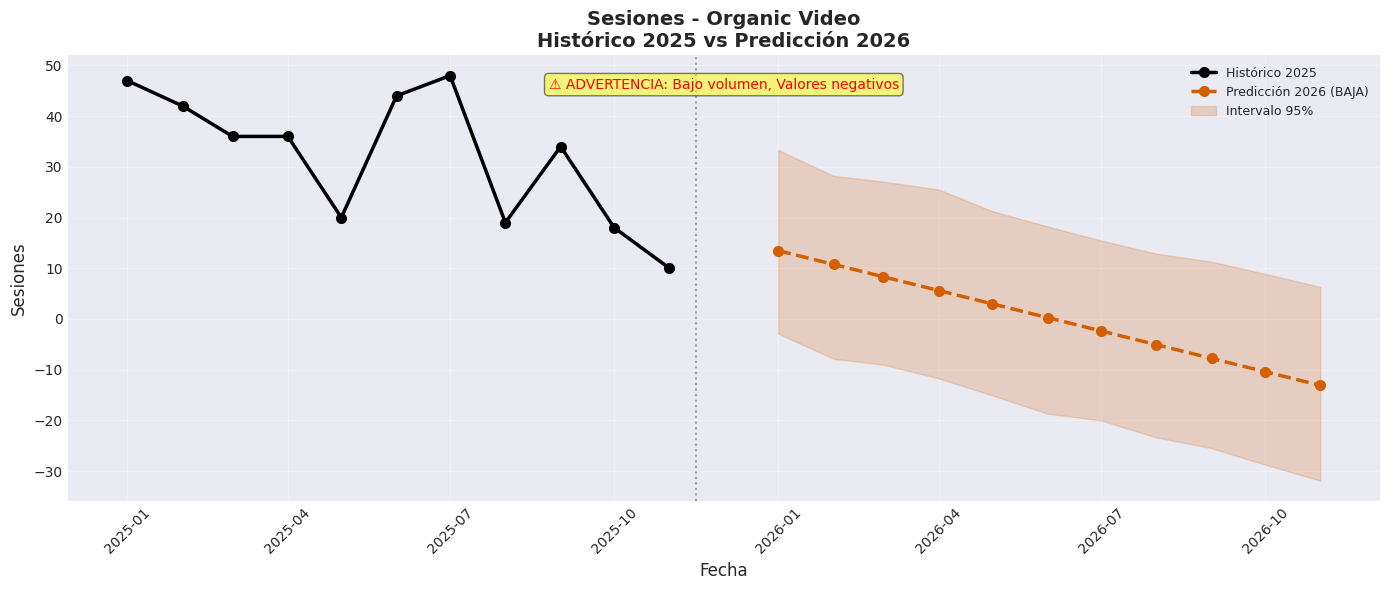

   Gráfico: Bounce Rate (%)


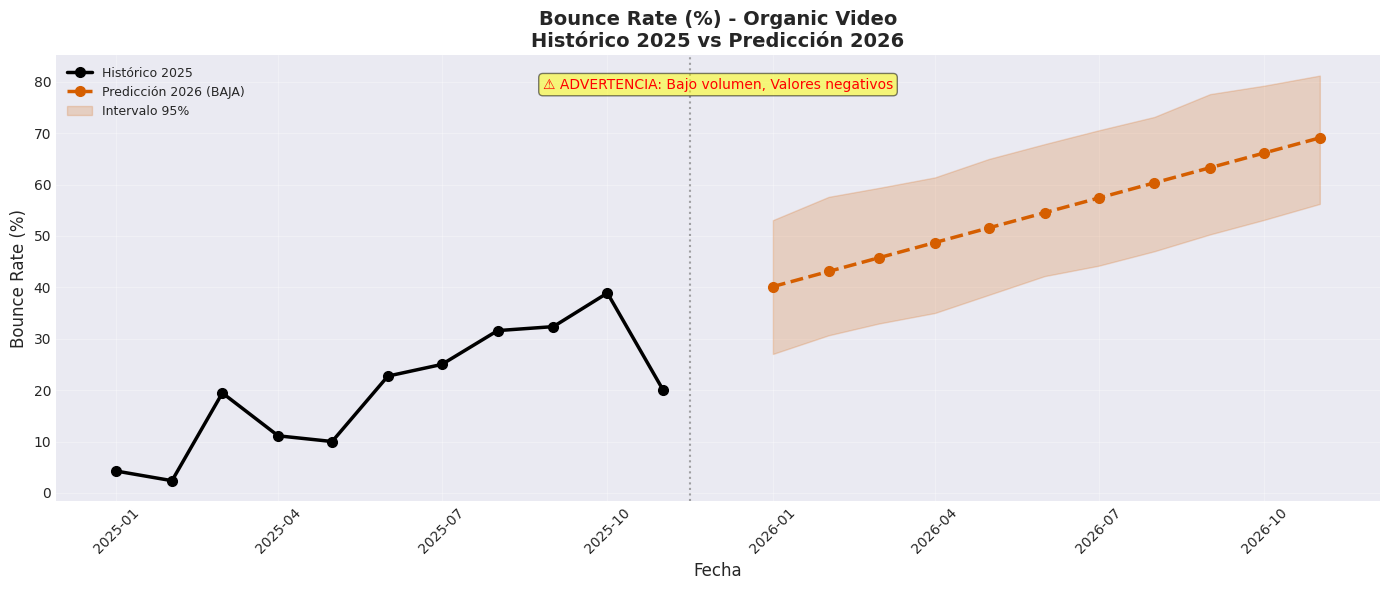

   Gráfico: Vistas por Sesión


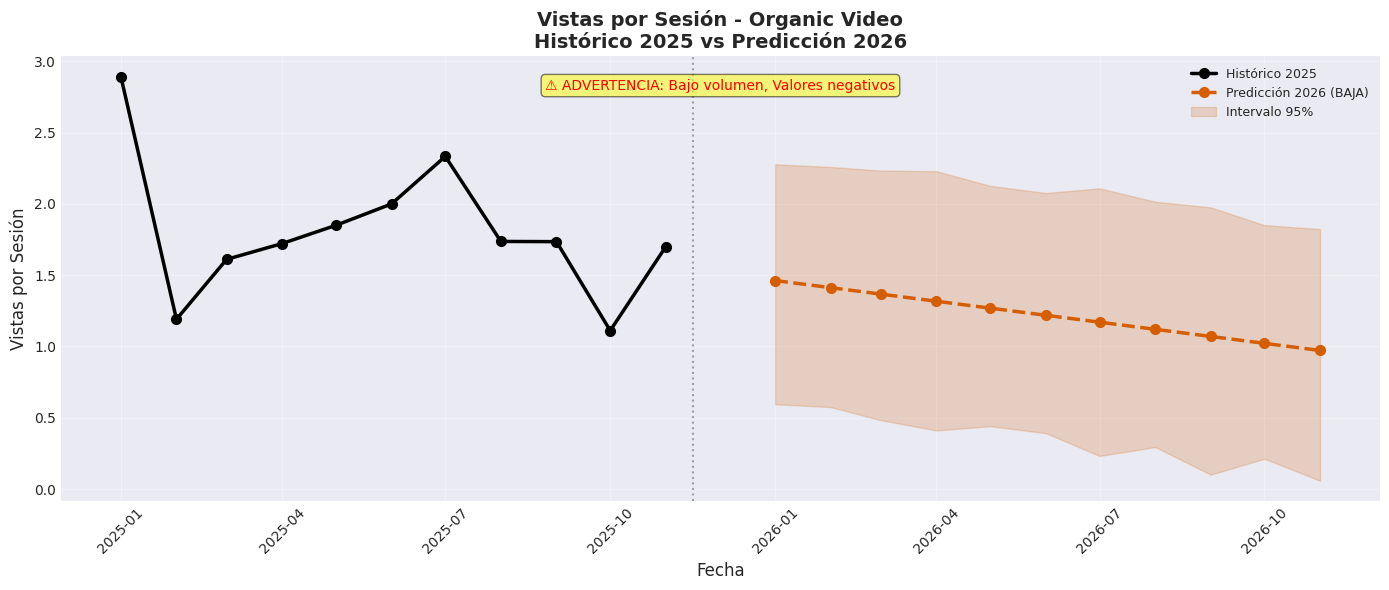

   Gráfico: Duración Promedio (segundos)


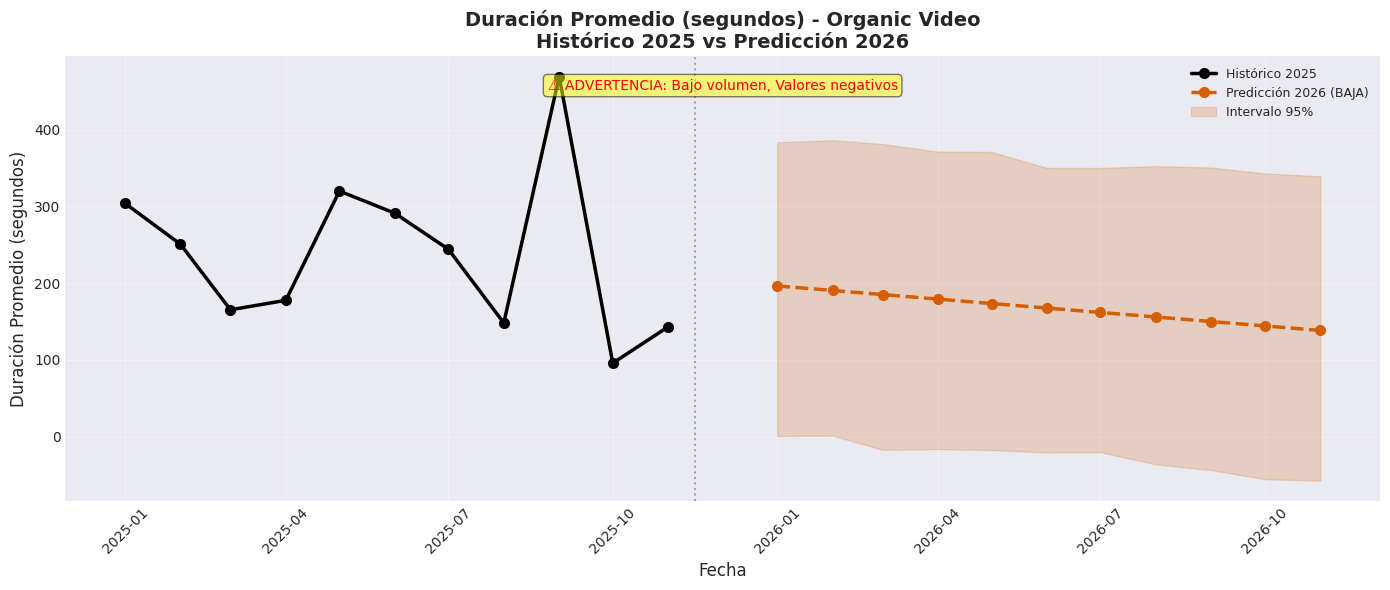


📈 Canal: QR Code
----------------------------------------------------------------------
   Gráfico: Sesiones


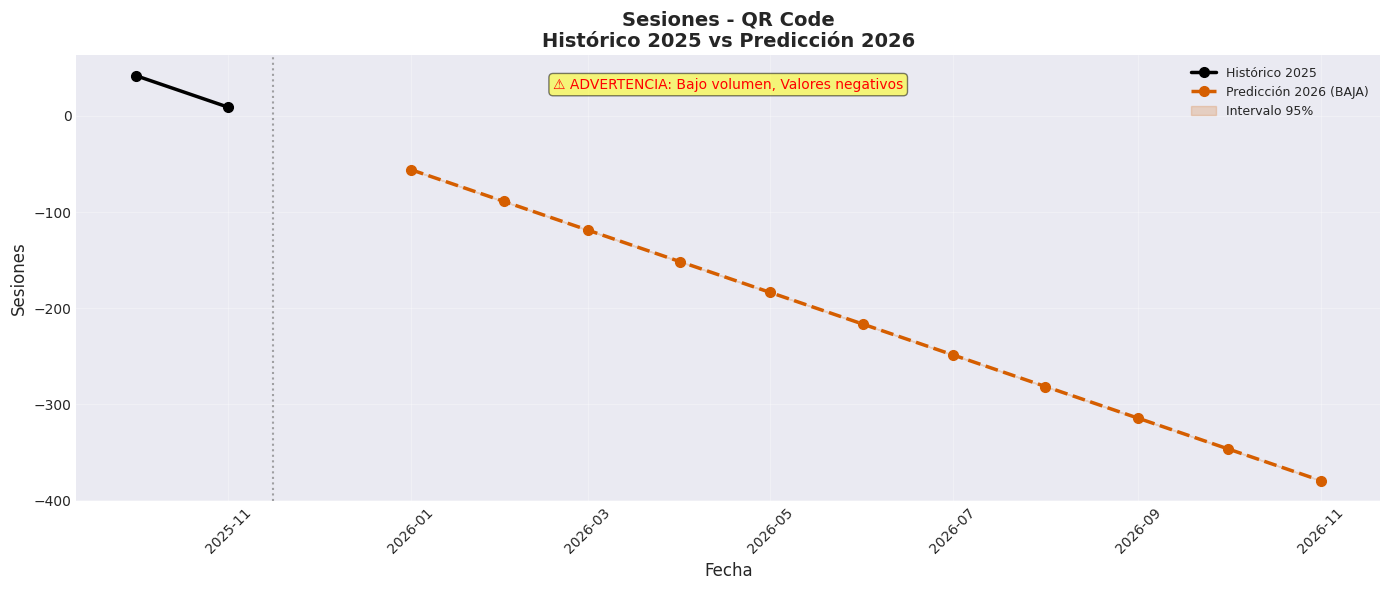

   Gráfico: Bounce Rate (%)


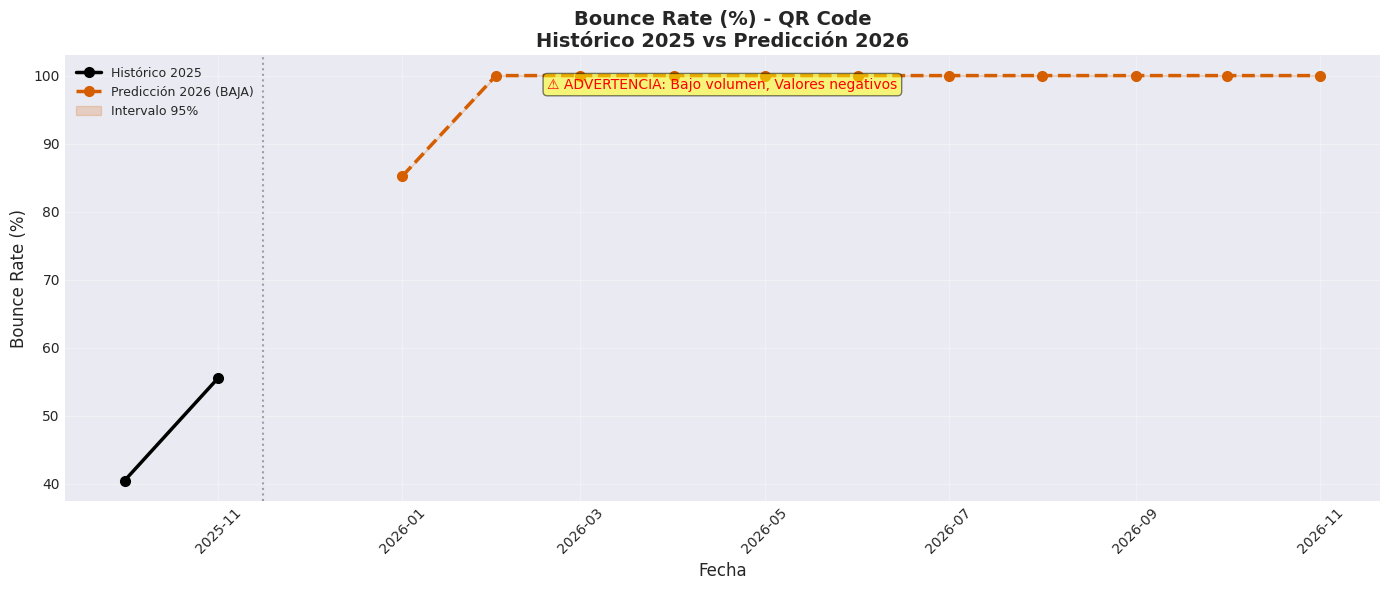

   Gráfico: Vistas por Sesión


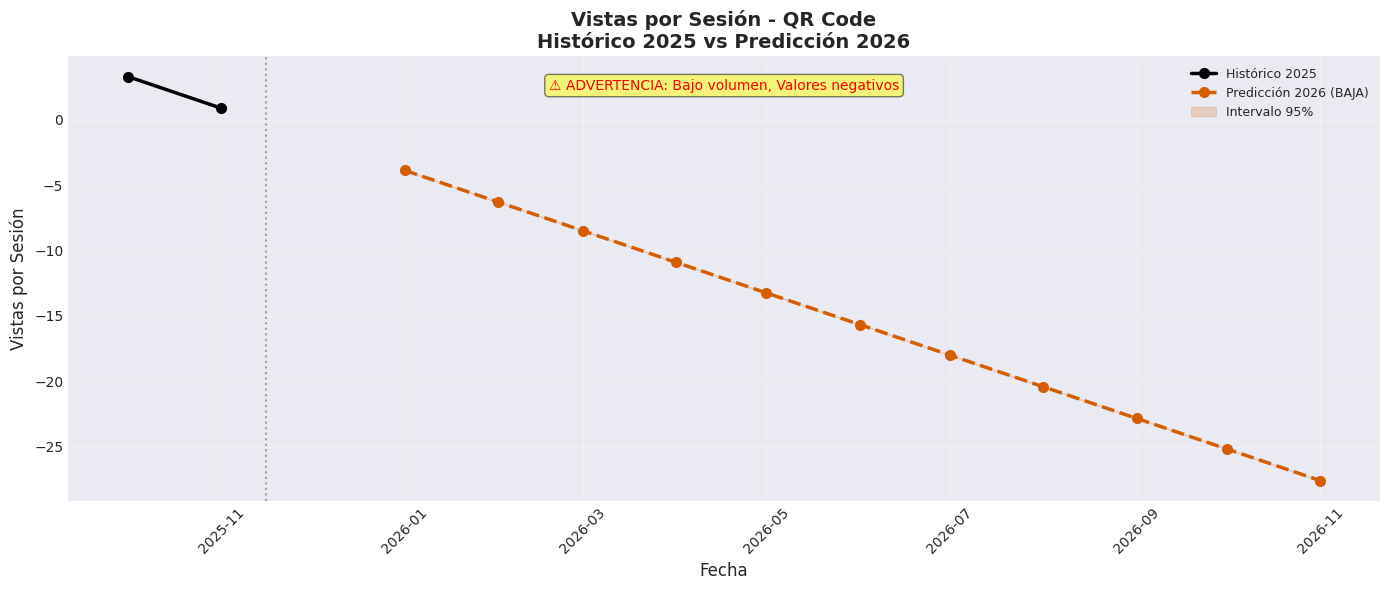

   Gráfico: Duración Promedio (segundos)


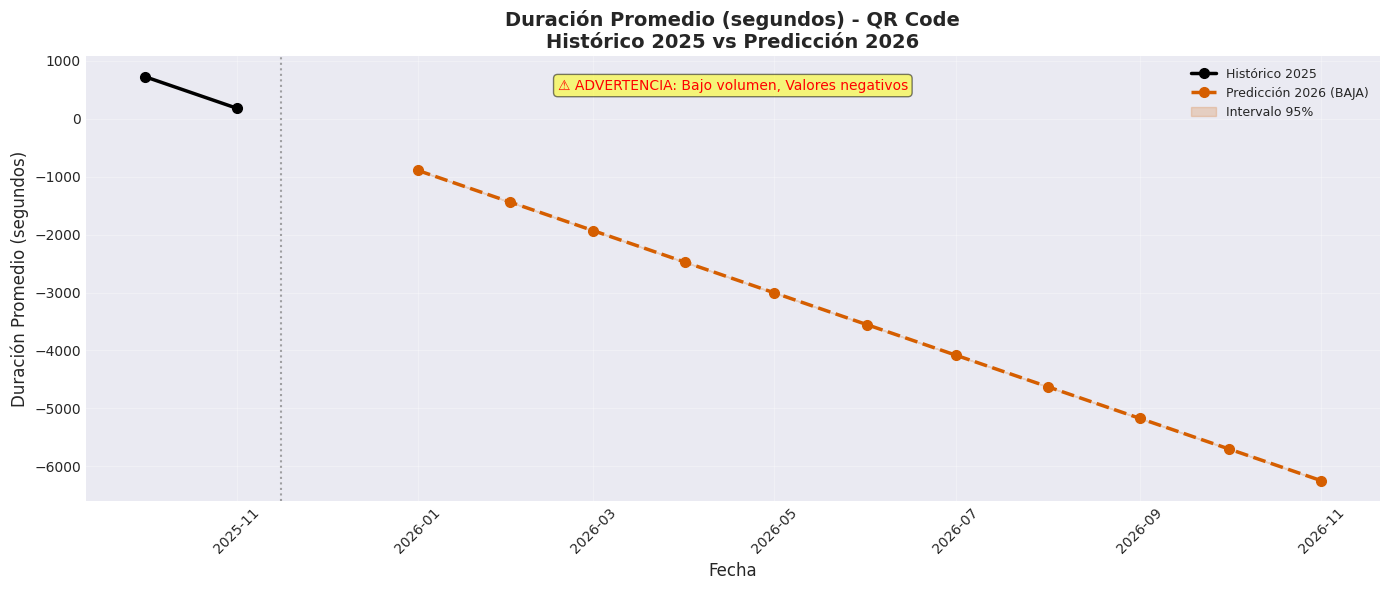


📈 Canal: Referral
----------------------------------------------------------------------
   Gráfico: Sesiones


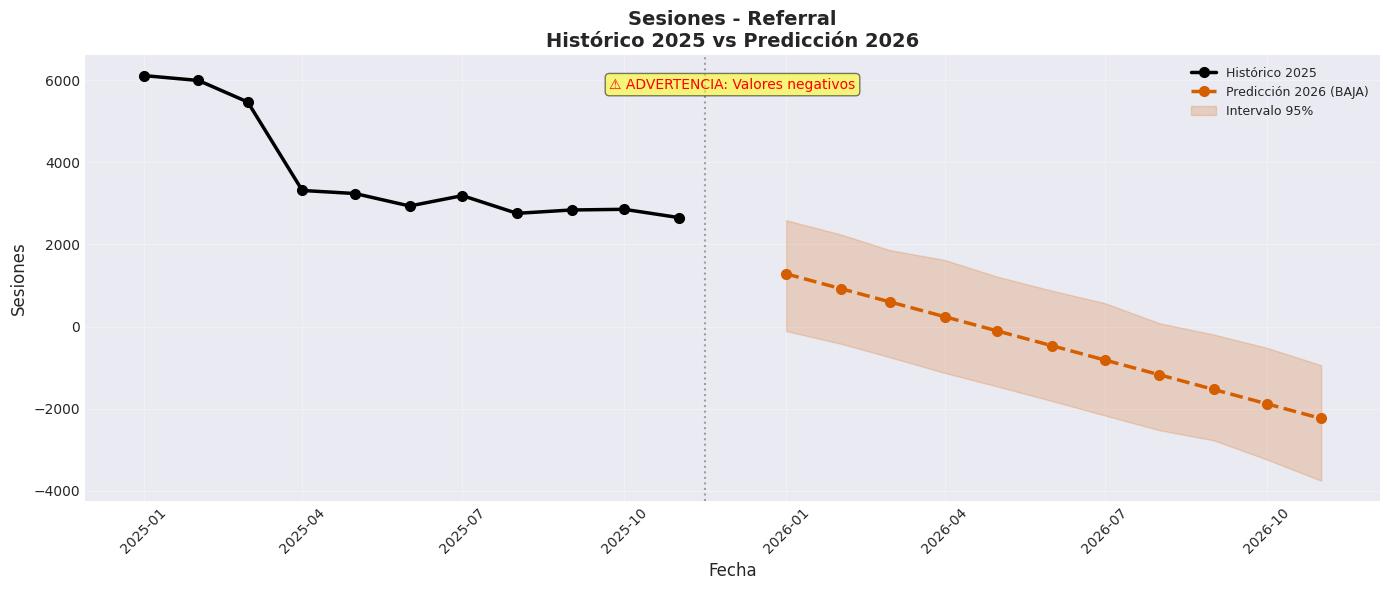

   Gráfico: Bounce Rate (%)


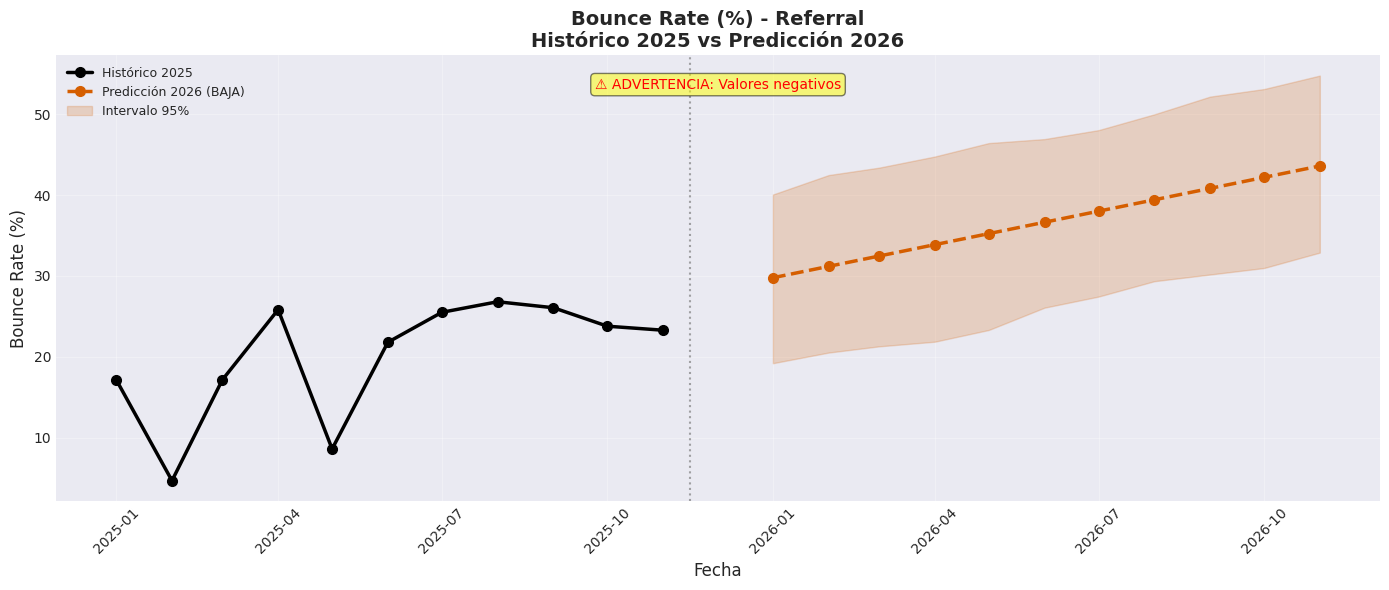

   Gráfico: Vistas por Sesión


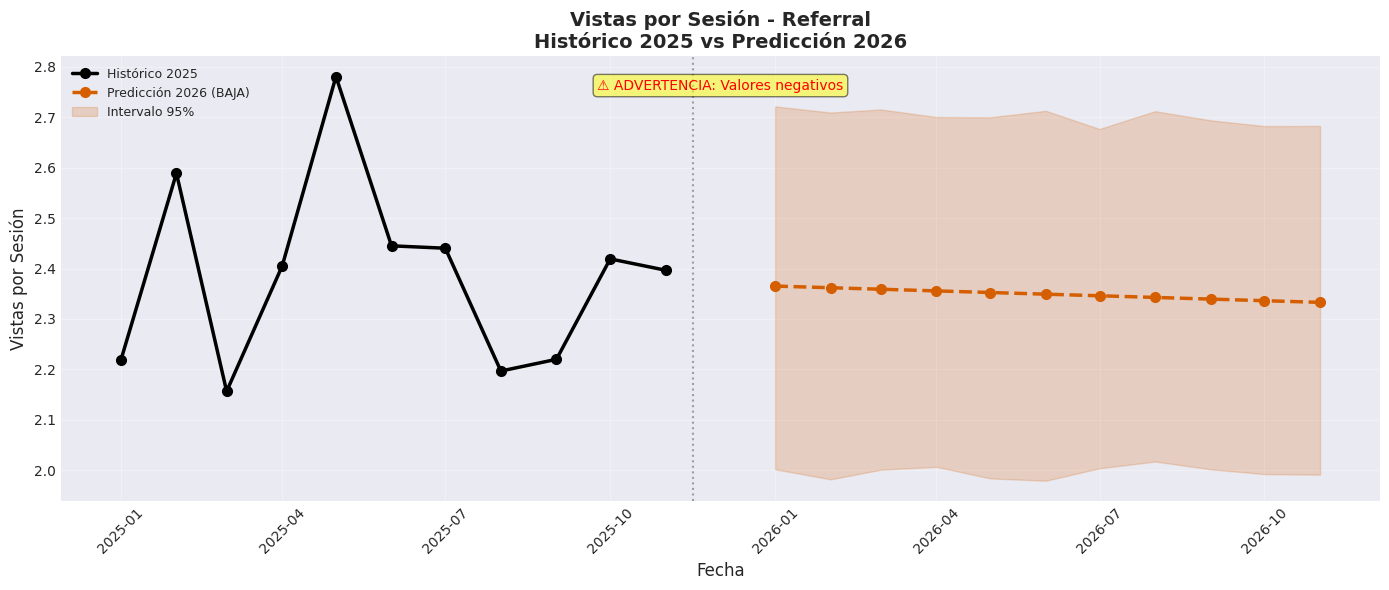

   Gráfico: Duración Promedio (segundos)


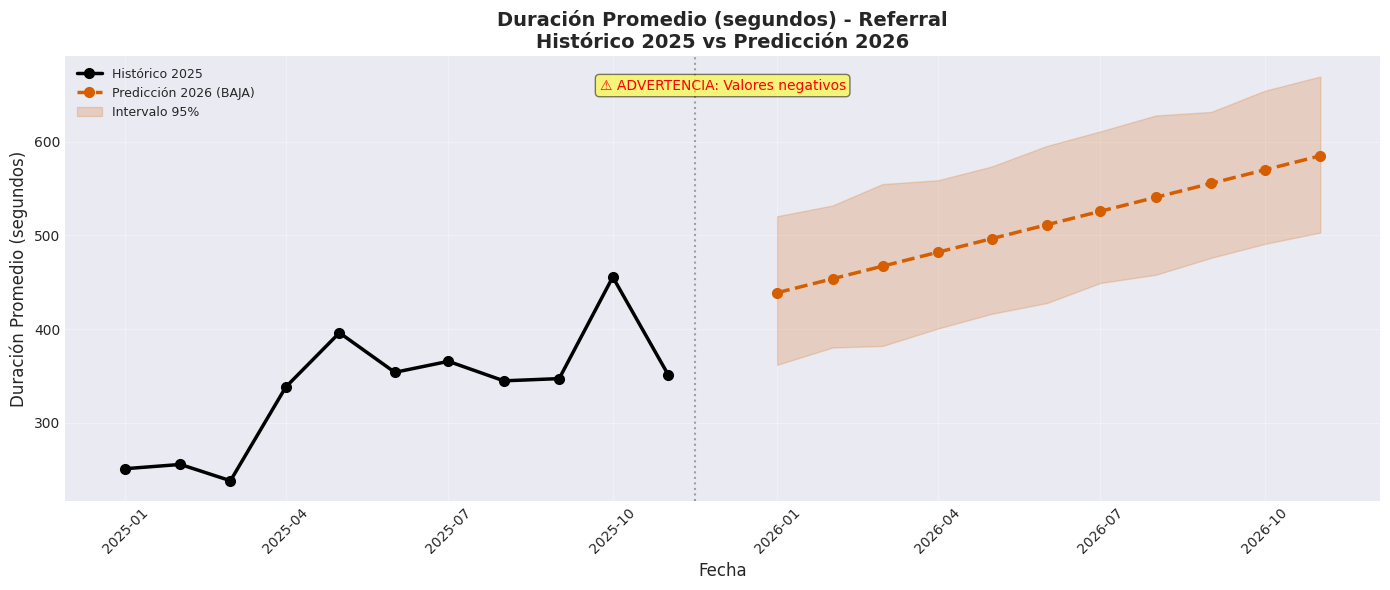


✅ 36 gráficos generados y guardados
📁 Ubicación: ../results/figures/final


In [23]:
# Generar gráficos para TODAS las métricas de TODOS los canales
print("📊 Generando gráficos comparativos para todas las métricas...\n")

metricas_titulos = {
    'sessions': 'Sesiones',
    'bounce_rate': 'Bounce Rate (%)',
    'views_per_session': 'Vistas por Sesión',
    'avg_session_duration': 'Duración Promedio (segundos)'
}

graficos_generados = 0

for canal in canales:
    print(f"\n📈 Canal: {canal}")
    print("-" * 70)
    
    for metrica, titulo in metricas_titulos.items():
        print(f"   Gráfico: {titulo}")
        
        fig, ax = plt.subplots(figsize=(14, 6))
        
        # Histórico
        df_hist = df_output[df_output['channel'] == canal].sort_values('ds')
        ax.plot(df_hist['ds'], df_hist[metrica], 
                'o-', color='black', label='Histórico 2025', linewidth=2.5, markersize=7)
        
        # Predicción
        df_pred = df_predicciones[(df_predicciones['channel'] == canal) & 
                                  (df_predicciones['metric'] == metrica)].sort_values('ds')
        
        conf = df_confiabilidad[df_confiabilidad['canal'] == canal]['confiabilidad'].values[0]
        color = '#0072B2' if conf in ['ALTA', 'MEDIA'] else '#D55E00'
        linestyle = '-' if conf in ['ALTA', 'MEDIA'] else '--'
        
        ax.plot(df_pred['ds'], df_pred['predicted_value'], 
                'o-', color=color, label=f'Predicción 2026 ({conf})', 
                linewidth=2.5, markersize=7, linestyle=linestyle)
        
        ax.fill_between(df_pred['ds'], df_pred['lower_bound'], df_pred['upper_bound'],
                        alpha=0.2, color=color, label='Intervalo 95%')
        
        # Línea separadora
        fecha_sep = df_hist['ds'].max() + pd.DateOffset(days=15)
        ax.axvline(x=fecha_sep, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
        
        # Advertencia si baja confiabilidad
        if conf == 'BAJA':
            problemas = df_confiabilidad[df_confiabilidad['canal'] == canal]['problemas'].values[0]
            ax.text(0.5, 0.95, f'⚠️ ADVERTENCIA: {problemas}', 
                    transform=ax.transAxes, fontsize=10, color='red',
                    ha='center', va='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
        
        ax.set_title(f'{titulo} - {canal}\nHistórico 2025 vs Predicción 2026', 
                     fontsize=14, fontweight='bold')
        ax.set_xlabel('Fecha', fontsize=12)
        ax.set_ylabel(titulo, fontsize=12)
        ax.legend(loc='best', fontsize=9)
        ax.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        filename = f"comp_{metrica}_{canal.replace(' ', '_').lower()}.png"
        plt.savefig(RESULTS_FIGURES_FINAL / filename, dpi=300, bbox_inches='tight')
        plt.show()
        
        graficos_generados += 1

print(f"\n" + "="*70)
print(f"✅ {graficos_generados} gráficos generados y guardados")
print(f"📁 Ubicación: {RESULTS_FIGURES_FINAL}")

## 4.5 Resumen ejecutivo

In [24]:
# Resumen ejecutivo final
print("="*80)
print("🎯 RESUMEN EJECUTIVO - PREDICCIONES 2026")
print("="*80)

print("\n📊 PREDICCIONES POR CANAL:\n")

for canal in sorted(canales):
    conf = df_confiabilidad[df_confiabilidad['canal'] == canal]['confiabilidad'].values[0]
    icono = '✅' if conf == 'ALTA' else ('⚠️' if conf == 'MEDIA' else '🚨')
    
    print(f"\n{icono} {canal} (Confiabilidad: {conf})")
    
    df_canal = df_predicciones[df_predicciones['channel'] == canal]
    
    sessions = df_canal[df_canal['metric'] == 'sessions']['predicted_value'].sum()
    bounce = df_canal[df_canal['metric'] == 'bounce_rate']['predicted_value'].mean()
    vps = df_canal[df_canal['metric'] == 'views_per_session']['predicted_value'].mean()
    dur = df_canal[df_canal['metric'] == 'avg_session_duration']['predicted_value'].mean()
    
    print(f"   Sesiones totales 2026: {sessions:,.0f}")
    print(f"   Bounce Rate promedio: {bounce:.1f}%")
    print(f"   Vistas/Sesión: {vps:.2f}")
    print(f"   Duración promedio: {segundos_a_hhmm_ss(dur)} ({dur:.0f} seg)")

print("\n" + "="*80)
print("\n✅ ANÁLISIS COMPLETADO")
print("="*80)

🎯 RESUMEN EJECUTIVO - PREDICCIONES 2026

📊 PREDICCIONES POR CANAL:


⚠️ AI Traffic (Confiabilidad: MEDIA)
   Sesiones totales 2026: 5,082
   Bounce Rate promedio: 41.0%
   Vistas/Sesión: 1.58
   Duración promedio: 00:05:11 (312 seg)

✅ Direct (Confiabilidad: ALTA)
   Sesiones totales 2026: 888,286
   Bounce Rate promedio: 70.1%
   Vistas/Sesión: 0.44
   Duración promedio: 00:01:05 (66 seg)

🚨 Email (Confiabilidad: BAJA)
   Sesiones totales 2026: 126
   Bounce Rate promedio: 96.8%
   Vistas/Sesión: -2.24
   Duración promedio: 00:00:00 (-72 seg)

✅ Organic Search (Confiabilidad: ALTA)
   Sesiones totales 2026: 464,905
   Bounce Rate promedio: 36.5%
   Vistas/Sesión: 1.67
   Duración promedio: 00:03:32 (212 seg)

🚨 Organic Shopping (Confiabilidad: BAJA)
   Sesiones totales 2026: -260
   Bounce Rate promedio: 99.8%
   Vistas/Sesión: 0.36
   Duración promedio: 03:00:12 (10812 seg)

✅ Organic Social (Confiabilidad: ALTA)
   Sesiones totales 2026: 17,366
   Bounce Rate promedio: 63.7%
   Vist

---
# 📥 SECCIÓN 5: DESCARGA DE RESULTADOS (Solo Colab)
---

In [25]:
if IN_COLAB:
    from google.colab import files
    import zipfile
    import os
    
    print("📦 Preparando archivos para descarga...\n")
    
    # Crear ZIP con todos los resultados
    zip_filename = 'resultados_forecast_promtur.zip'
    
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        # Agregar CSVs
        for file in ['data/processed/dataset_clean.csv', 
                     'data/forecasts/forecasts_2026_all_channels.csv',
                     'results/reports/canales_confiabilidad.csv']:
            if os.path.exists(file):
                zipf.write(file)
        
        # Agregar Excel
        if os.path.exists('results/reports/tablas_resumen_2026.xlsx'):
            zipf.write('results/reports/tablas_resumen_2026.xlsx')
        
        # Agregar gráficos
        for root, dirs, files_list in os.walk('results/figures'):
            for file in files_list:
                if file.endswith('.png'):
                    filepath = os.path.join(root, file)
                    zipf.write(filepath)
    
    print(f"✅ Archivo ZIP creado: {zip_filename}")
    print(f"📊 Total de gráficos incluidos: {graficos_generados}")
    print("\n📥 Descargando resultados...\n")
    
    files.download(zip_filename)
    
    print("\n" + "="*80)
    print("✅ DESCARGA COMPLETADA")
    print("="*80)
    print("\nEl archivo ZIP contiene:")
    print("  - Dataset limpio (CSV)")
    print("  - Predicciones 2026 (CSV)")
    print("  - Tablas resumen por canal (Excel con HH:MM:SS)")
    print("  - Análisis de confiabilidad (CSV)")
    print(f"  - {graficos_generados} gráficos comparativos (PNG)")
else:
    print("🟢 Entorno local: Todos los archivos están guardados en sus carpetas correspondientes")
    print(f"\n📊 Total de gráficos generados: {graficos_generados}")

🟢 Entorno local: Todos los archivos están guardados en sus carpetas correspondientes

📊 Total de gráficos generados: 36


---

## 🎉 ¡ANÁLISIS COMPLETADO!

### 📊 Archivos generados:

**Datos:**
- `data/processed/dataset_clean.csv` - Dataset limpio
- `data/forecasts/forecasts_2026_all_channels.csv` - Predicciones 2026

**Reportes:**
- `results/reports/tablas_resumen_2026.xlsx` - Tablas por canal con duración en HH:MM:SS
- `results/reports/canales_confiabilidad.csv` - Análisis de confiabilidad

**Visualizaciones:**
- `results/figures/exploratory/` - Gráficos exploratorios
- `results/figures/final/` - Gráficos comparativos de TODAS las métricas

---

### ⚠️ Consideraciones importantes:

1. **Bounce Rate**: Limitado automáticamente a rango 0-100%
2. **Canales con baja confiabilidad**: Señalizados en gráficos y análisis
3. **Intervalos de confianza**: Reflejan incertidumbre del modelo
4. **Duración de sesión**: Disponible en segundos y formato HH:MM:SS

### 🎯 Recomendaciones:

- Usar predicciones de canales con confiabilidad ALTA/MEDIA
- Considerar intervalos de confianza en planificación
- Actualizar modelos con datos reales de 2026
- Incorporar datos de 2024 cuando estén disponibles

---

**Desarrollado por:** Forecast Promtur Team  
**Fecha:** Noviembre 2025